# Init

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st 
from scipy.optimize import least_squares, curve_fit
import emcee

import os, time, json, math
from pathlib import Path
from tqdm.auto import tqdm
from copy import deepcopy

from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)

DAYS_PER_YEAR = 365.2425
DAYS_PER_MONTH = 30.4375
DAYS_PER_WEEK = 7.0
HOURS_PER_DAY = 24

# Liver

## Liver capacities $K$, $S$

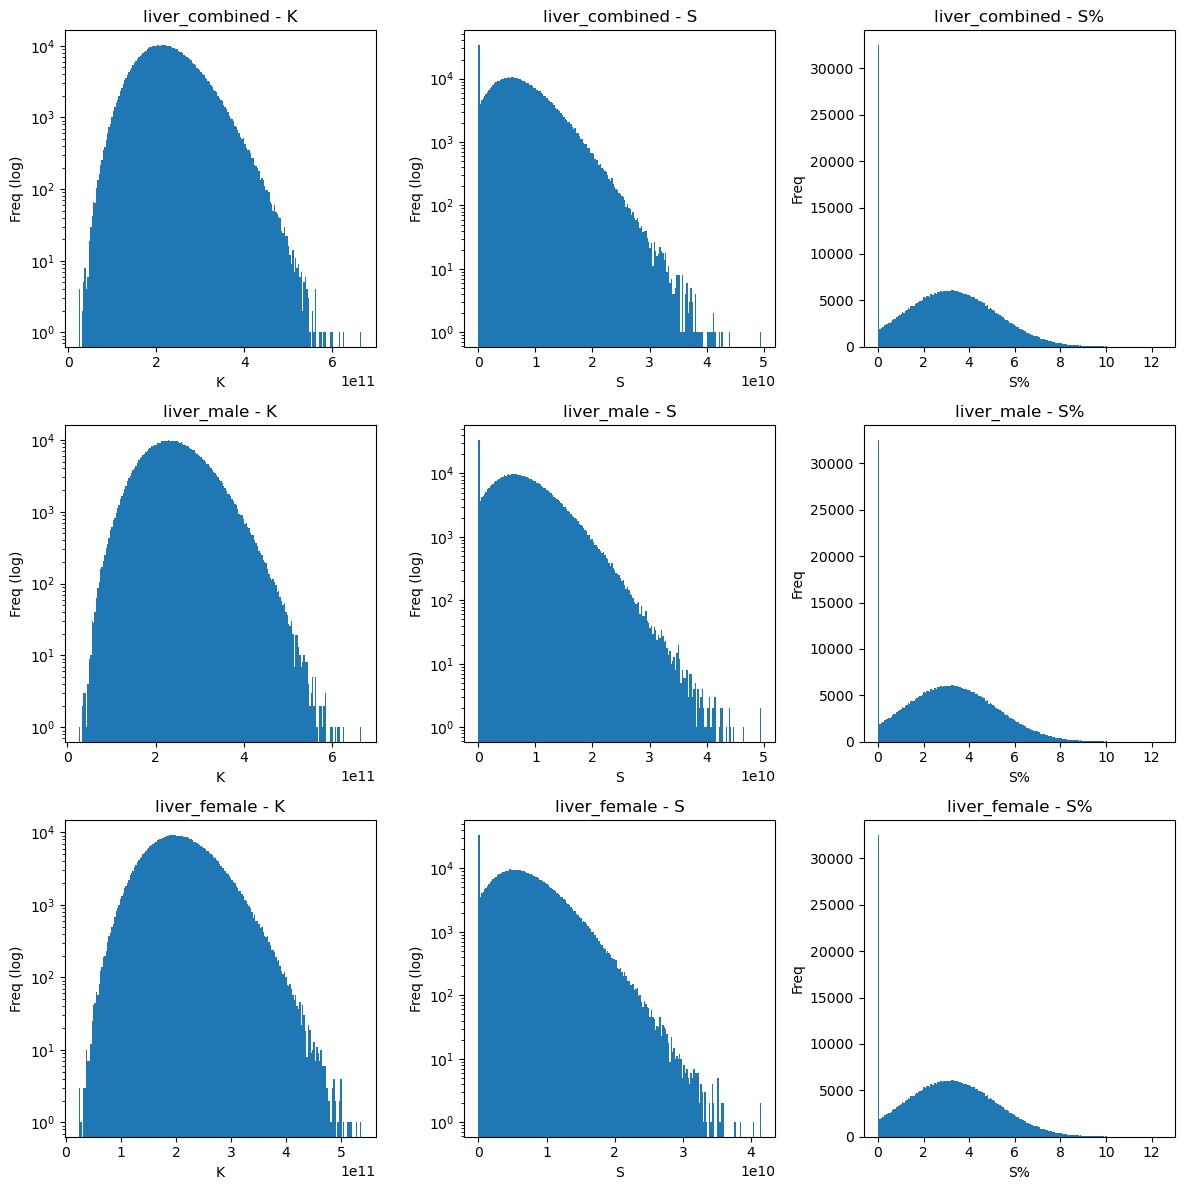

,liver_combined,liver_male,liver_female
metric,,,
K_mean,2.26e+11,2.44e+11,2.08e+11
K_low,1.15e+11,1.27e+11,1.08e+11
K_high,3.65e+11,3.85e+11,3.29e+11
S_mean,7.26e+09,7.82e+09,6.69e+09
S_low,2.21e+05,2.40e+05,2.05e+05
S_high,1.88e+10,2.00e+10,1.71e+10
S_pct_mean,3.21e+00,3.21e+00,3.21e+00
S_pct_low,1.06e-04,1.06e-04,1.06e-04
S_pct_high,7.15e+00,7.15e+00,7.15e+00


In [ ]:
N = 5e5
out_dir = "./params/liver"
os.makedirs(out_dir, exist_ok=True)
p_low, p_high = 2.5, 97.5

hep_per_g_mean = 139e6; hep_per_g_sd = 25e6
liver_male_median = 1754.0; liver_female_median = 1500.0
liver_male_sd = liver_male_median * 0.20; liver_female_sd = liver_female_median * 0.20
lsc_frac_mean = 0.0295; lsc_frac_sd = 0.0191

hep_per_g = np.random.normal(hep_per_g_mean, hep_per_g_sd, size=N); hep_per_g = np.clip(hep_per_g,1e6,None)
liver_male_mass = np.random.normal(liver_male_median, liver_male_sd, size=N); liver_male_mass = np.clip(liver_male_mass,500,None)
liver_female_mass = np.random.normal(liver_female_median, liver_female_sd, size=N); liver_female_mass = np.clip(liver_female_mass,400,None)
is_male = np.random.rand(N) < 0.5
liver_combined_mass = np.where(is_male, liver_male_mass, liver_female_mass)
lsc_frac = np.random.normal(lsc_frac_mean, lsc_frac_sd, size=N); lsc_frac = np.clip(lsc_frac,1e-6,0.30)

chol_frac = np.random.normal(0.04,0.01,size=N); chol_frac = np.clip(chol_frac,0.01,0.08)
hep_frac = np.random.normal(0.60,0.10,size=N); hep_frac = np.clip(hep_frac,0.40,0.80)
epithelial_multiplier = 1.0 + (chol_frac / hep_frac)

def summarize_with_se(draws):
    mean = float(np.mean(draws))
    sd = float(np.std(draws, ddof=1))
    q_lo = float(np.percentile(draws, p_low))
    q_hi = float(np.percentile(draws, p_high))
    se_mean = sd / math.sqrt(N)
    counts, bins = np.histogram(draws, bins=2000)
    bin_width = bins[1] - bins[0]
    # for q_lo
    idx_lo = np.searchsorted(bins, q_lo) - 1
    idx_lo = max(0, min(len(counts)-1, idx_lo))
    f_lo = counts[idx_lo] / (N * bin_width) if counts[idx_lo] > 0 else np.nan
    se_q_lo = math.sqrt(p_low/100*(1-p_low/100)/(N * (f_lo**2))) if f_lo and f_lo>0 else float('nan')
    # for q_hi
    idx_hi = np.searchsorted(bins, q_hi) - 1
    idx_hi = max(0, min(len(counts)-1, idx_hi))
    f_hi = counts[idx_hi] / (N * bin_width) if counts[idx_hi] > 0 else np.nan
    se_q_hi = math.sqrt(p_high/100*(1-p_high/100)/(N * (f_hi**2))) if f_hi and f_hi>0 else float('nan')
    return {"mean":mean, "sd":sd, "se_mean":se_mean, "low":q_lo, "high":q_hi, "se_low":se_q_lo, "se_high":se_q_hi}

results = {}
for label, mass in [("liver_combined", liver_combined_mass), ("liver_male", liver_male_mass), ("liver_female", liver_female_mass)]:
    K = hep_per_g * mass
    epithelial = K * epithelial_multiplier
    S = epithelial * lsc_frac
    S_pct = (S / K) * 100.0
    results[label] = {"K": summarize_with_se(K), "S": summarize_with_se(S), "S_pct": summarize_with_se(S_pct)}

rows = []
for metric in ["K","S","S_pct"]:
    for stat in ["mean","low","high"]:
        key = f"{metric}_{stat}"
        row = {"metric": key,
               "liver_combined": results["liver_combined"][metric][stat],
               "liver_male": results["liver_male"][metric][stat],
               "liver_female": results["liver_female"][metric][stat]}
        rows.append(row)
df_transposed = pd.DataFrame(rows).set_index("metric")
csv_path = os.path.join(out_dir, "liver_sohlenius_500k_transposed.csv")
df_transposed.to_csv(csv_path)

# SE estimates DF
se_rows = []
for label in ["liver_combined","liver_male","liver_female"]:
    for metric in ["K","S","S_pct"]:
        d = results[label][metric]
        se_rows.append({"label":label,"metric":metric,"mean":d["mean"],"sd":d["sd"],"se_mean":d["se_mean"],
                        "low":d["low"],"low_se":d["se_low"],"high":d["high"],"high_se":d["se_high"]})
df_se = pd.DataFrame(se_rows)
df_se.to_csv(os.path.join(out_dir, "liver_sohlenius_500k_se_estimates.csv"), index=False)

# Multi-panel PDF
fig, axes = plt.subplots(3,3, figsize=(12,12))
labels = ["liver_combined","liver_male","liver_female"]
for i,label in enumerate(labels):
    mass = liver_combined_mass if label=="liver_combined" else (liver_male_mass if label=="liver_male" else liver_female_mass)
    K_draws = hep_per_g * mass
    epithelial_draws = K_draws * epithelial_multiplier
    S_draws = epithelial_draws * lsc_frac
    S_pct_draws = (S_draws / K_draws) * 100.0
    axes[i,0].hist(K_draws, bins=200, log=True); axes[i,0].set_title(f"{label} - K"); axes[i,0].set_xlabel("K"); axes[i,0].set_ylabel("Freq (log)")
    axes[i,1].hist(S_draws, bins=200, log=True); axes[i,1].set_title(f"{label} - S"); axes[i,1].set_xlabel("S"); axes[i,1].set_ylabel("Freq (log)")
    axes[i,2].hist(S_pct_draws, bins=200); axes[i,2].set_title(f"{label} - S%"); axes[i,2].set_xlabel("S%"); axes[i,2].set_ylabel("Freq")
plt.tight_layout()
pdf_path = os.path.join(out_dir, "liver_sohlenius_500k_multi_panel.pdf")
plt.savefig(pdf_path, dpi=150)
plt.show(fig)

meta = {"N":N,"note":"500k draws; Sohlenius hepatocellularity; CAP medians; Liu lsc fraction; sampled chol_frac/hep_frac priors.","sources":{"sohlenius":"PMID 16930941","liu_2025":"PMID 40008906"}}
with open(os.path.join(out_dir,"metadata.json"),"w") as fh: json.dump(meta, fh, indent=2)

display_df = df_transposed.copy()
display_df = display_df.map(lambda x: f"{x:,.2e}")
csv_path, os.path.join(out_dir,"liver_sohlenius_500k_se_estimates.csv"), pdf_path

display_df

## Replication rate $r$

## chk5

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.optimize import minimize
import emcee, math, time
from typing import Dict, Tuple, List

r_studies = {
    'SABLE_2018': {
        'times_days': np.array([  1,   3,   5,   6,   7,   2,   5,   7,  10,  11,  12,  14,   5,
                                  10,  12,  15,  18,  20,  21,  22,  40,  40,  41,  42,  43,  46,
                                  75, 120 ]),
        'X_frac': np.array([0.34,0.47,0.65,0.51,0.90,0.36,0.63,0.70,0.89,0.92,0.82,0.94,0.45,0.67,0.68,
                             0.74,0.88,1.20,0.90,1.28,0.70,0.82,0.81,0.80,0.72,0.84,1.11,0.74]),
        'notes': 'Approximate digitization from Figure 1. Times in days; X as fraction of TLV; no CIs.'
    },

    'KIM_2024_GROUP_A': {
        'times_days': np.array([0, 7.0, 91.3125]),
        'X_frac': np.array([0.296, 0.561, 0.813]),
        'X_frac_ci': np.array([0.018, 0.075, 0.134]),
    },

    'KIM_2024_GROUP_B': {
        'times_days': np.array([0, 7.0, 91.3125]),
        'X_frac': np.array([0.367, 0.563, 0.762]),
        'X_frac_ci': np.array([0.048, 0.078, 0.107]),
    },

    'WANG_2024_REMNANT_RIGHT': {
        'times_days': np.array([0.0, 30.4375, 182.625, 365.25]),
        'X_frac': np.array([0.75, 0.78, 0.88, 0.9]),
        'X_frac_ci': np.array([0.07, 0.25, 0.14, 0.1]),
    },

    'WANG_2024_REMNANT_LEFT': {
        'times_days': np.array([0.0, 30.4375, 182.625, 365.25]),
        'X_frac': np.array([0.5, 0.76, 0.88, 0.9]),
        'X_frac_ci': np.array([0.1, 0.3, 0.27, 0.2]),
    },

    'GONG_2019': {
        'times_days': np.array([0., 7., 35., 63., 91.]),
        'X_frac': np.array([0.65671642, 0.78606965, 0.82089552, 0.84577114, 0.85074627]),
        'X_frac_ci': np.array([0.19900498, 0.17910448, 0.17412935, 0.1641791 , 0.1641791 ]),
    },

    'IBIS_2017_RHH': {
        'times_days': np.array([0.0, 7.0, 31.0]),
        'X_frac': np.array([0.35354273, 0.65741417, 0.73338203]),
        'X_frac_ci': np.array([0.17823229, 0.18626735, 0.19101534]),
    },

    'IBIS_2017_LLS': {
        'times_days': np.array([0.0, 7.0, 31.0]),
        'X_frac': np.array([0.81196013, 0.97674419, 0.90564784]),
        'X_frac_ci': np.array([0.27109635, 0.2654485 , 0.35614618]),
    },

    'YAMAMOTO_2016': {
        'times_days': np.array([1, 7, 30, 60, 150, 365, 730]),
        'X_frac': np.array([0.82188466, 0.87539964, 0.83130982, 0.9466702 , 0.94646015, 0.95550741, 0.94372618]),
        'X_frac_ci': np.array([0.02606226, 0.05370439, 0.06625629, 0.03977659, 0.02516157, 0.0352281 , 0.04189607]),
    }
}

K = 1.0
R_BOUNDS = (1e-4, 0.7) # 1/day
X0_BOUNDS = (0.05, 0.99)
RES_R = 1000 # grid resolution for the frequentist approach
RES_X0 = 500
SIGMA_FLOOR = 1e-3

BAYES_NWALKERS = 32
BAYES_NSTEPS = 1000
BAYES_BURN = 250

# ----------------------
# Helpers
# ----------------------

def logistic_solution(t, r, x0, K=1.0):
    A = (K - x0) / np.maximum(x0, 1e-12)
    return K / (1.0 + A * np.exp(-r * t))

def prepare_dataset(d):
    t = np.asarray(d['times_days'], dtype=float)
    x = np.asarray(d['X_frac'], dtype=float)
    x = np.minimum(x, K)  # truncate above K
    order = np.argsort(t)
    t = t[order]; x = x[order]
    if 'X_frac_ci' in d and d.get('X_frac_ci') is not None:
        ci = np.asarray(d['X_frac_ci'], dtype=float)[order]
        sigma = np.maximum(ci / 1.96, SIGMA_FLOOR)
    else:
        sigma = None
    return dict(t=t, x=x, sigma=sigma)

prepared = {name: prepare_dataset(d) for name,d in r_studies.items()}

# Grouping based on earliest observed X0
group_LB, group_MEAN, group_UB = [], [], []
for name, ds in prepared.items():
    x0_obs = float(ds['x'][0])
    if 0.7 <= x0_obs <= 1.0:
        group_LB.append(name)
    elif 0.0 <= x0_obs <= 0.35:
        group_UB.append(name)
    else:
        group_MEAN.append(name)
groups = {'LB': group_LB, 'MEAN': group_MEAN, 'UB': group_UB}

# ----------------------
# Frequentist: per-dataset and group profile likelihood (vectorized)
# ----------------------

r_grid = np.linspace(R_BOUNDS[0], R_BOUNDS[1], RES_R)
x0_grid = np.linspace(X0_BOUNDS[0], X0_BOUNDS[1], RES_X0)
CHI2_95_1DF = st.chi2.ppf(0.95, df=1.0)

def profile_loglike_over_r(t, x, sigma, r_grid, x0_grid, K=1.0):
    # returns profile log-likelihood over r (maximized over x0)
    if sigma is None:
        sigma = np.ones_like(x)
    # compute predictions for all combos r,x0,t
    # shapes: (R, X0, T)
    R = r_grid.size; X0N = x0_grid.size; T = t.size
    rt = r_grid[:, None, None] * t[None, None, :]
    x0m = x0_grid[None, :, None]
    A = (K - x0m) / np.maximum(x0m, 1e-12)
    pred = K / (1.0 + A * np.exp(-rt))
    resid = (x[None, None, :] - pred) / sigma[None, None, :]
    ll = -0.5 * np.sum(resid**2, axis=2)  # shape (R, X0)
    argmax_x0_idx = np.argmax(ll, axis=1)
    ll_profile = ll[np.arange(R), argmax_x0_idx]
    x0_at_max = x0_grid[argmax_x0_idx]
    return ll_profile, x0_at_max

def profile_ci_r(r_grid, ll_profile, alpha=0.05):
    llmax = np.max(ll_profile)
    threshold = llmax - 0.5 * st.chi2.ppf(1-alpha, df=1)
    mask = ll_profile >= threshold
    if not np.any(mask):
        return r_grid[0], r_grid[-1]
    idx = np.where(mask)[0]
    return float(r_grid[idx[0]]), float(r_grid[idx[-1]])

# compute per-dataset frequentist fits
per_dataset_freq = {}
for name, ds in prepared.items():
    sigma_eff = None if (name == 'SABLE_2018') else ds['sigma']
    ll_profile, x0_at_max = profile_loglike_over_r(ds['t'], ds['x'], sigma_eff, r_grid, x0_grid, K)
    idx = int(np.argmax(ll_profile))
    r_hat = float(r_grid[idx])
    x0_hat = float(x0_at_max[idx])
    r_lo, r_hi = profile_ci_r(r_grid, ll_profile)
    per_dataset_freq[name] = dict(r_hat=r_hat, r_lo=r_lo, r_hi=r_hi, x0_hat=x0_hat, ll_profile=ll_profile)

# Group frequentist: sum profile log-likelihoods across datasets (independent)
group_freq = {}
for gname, dnames in groups.items():
    if len(dnames) == 0:
        continue
    ll_sum = np.zeros_like(r_grid)
    for dn in dnames:
        sigma_eff = None if (dn == 'SABLE_2018') else prepared[dn]['sigma']
        ll_profile, _ = profile_loglike_over_r(prepared[dn]['t'], prepared[dn]['x'], sigma_eff, r_grid, x0_grid, K)
        ll_sum += ll_profile
    idx = int(np.argmax(ll_sum))
    r_hat = float(r_grid[idx])
    r_lo, r_hi = profile_ci_r(r_grid, ll_sum)
    # representative x0: weighted median of per-dataset x0_hat weighted by peak likelihood at r_hat
    x0s = np.array([per_dataset_freq[dn]['x0_hat'] for dn in dnames])
    weights = np.array([np.exp(np.max(profile_loglike_over_r(prepared[dn]['t'], prepared[dn]['x'], None if (dn=='SABLE_2018') else prepared[dn]['sigma'], np.array([r_hat]), x0_grid, K)[0])) for dn in dnames])
    # weighted median
    order = np.argsort(x0s); x0s_s = x0s[order]; w_s = weights[order]
    csum = np.cumsum(w_s)/np.sum(w_s)
    idx_m = np.searchsorted(csum, 0.5)
    x0_rep = float(x0s_s[min(idx_m, x0s_s.size-1)])
    group_freq[gname] = dict(r_hat=r_hat, r_lo=r_lo, r_hi=r_hi, x0_rep=x0_rep, ll_sum=ll_sum)

def log_prior_r_x0(r, x0):
    if not (R_BOUNDS[0] <= r <= R_BOUNDS[1] and X0_BOUNDS[0] <= x0 <= X0_BOUNDS[1]):
        return -np.inf
    return 0.0

def log_likelihood_dataset(params, t, x, sigma):
    # params = [r, x0]
    r, x0 = params
    pred = logistic_solution(t, r, x0, K)
    if sigma is None:
        # unweighted: assume small sigma floor
        sigma = np.ones_like(x) * 0.05
    resid = (x - pred) / sigma
    return -0.5 * np.sum(resid**2)

def run_emcee_dataset(name, ds, nwalkers=BAYES_NWALKERS, nsteps=BAYES_NSTEPS, burn=BAYES_BURN):
    t, x, sigma = ds['t'], ds['x'], ds['sigma']
    # log-posterior over (r,x0)
    def log_prob(theta):
        r, x0 = theta
        lp = log_prior_r_x0(r, x0)
        if not np.isfinite(lp): return -np.inf
        return lp + log_likelihood_dataset((r,x0), t, x, sigma)
    ndim = 2
    # initialize walkers in small ball around frequentist estimates if available
    r0 = per_dataset_freq[name]['r_hat'] if name in per_dataset_freq else 0.01
    x00 = per_dataset_freq[name]['x0_hat'] if name in per_dataset_freq else float(ds['x'][0])
    p0 = np.vstack([
        np.random.normal(r0, 0.1*r0+1e-4, size=nwalkers),
        np.random.normal(x00, 0.05, size=nwalkers)
    ]).T
    # ensure within bounds
    for i in range(nwalkers):
        if not (R_BOUNDS[0] <= p0[i,0] <= R_BOUNDS[1]):
            p0[i,0] = np.clip(p0[i,0], R_BOUNDS[0], R_BOUNDS[1])
        p0[i,1] = np.clip(p0[i,1], X0_BOUNDS[0], X0_BOUNDS[1])
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
    sampler.run_mcmc(p0, nsteps, progress=False)
    samples = sampler.get_chain(discard=burn, flat=True)
    logprob = sampler.get_log_prob(discard=burn, flat=True)
    return samples, logprob, sampler

# Run per-dataset emcee
per_dataset_bayes = {}
for name, ds in prepared.items():
    if name == 'SABLE_2018':
        # SABLE no CI -> treat as unweighted but still sample
        pass
    samples, logprob, sampler = run_emcee_dataset(name, ds)
    r_samples = samples[:,0]
    x0_samples = samples[:,1]
    # compute mean and 95% credible interval (equal-tailed)
    r_mean = float(np.mean(r_samples))
    r_lo = float(np.quantile(r_samples, 0.025))
    r_hi = float(np.quantile(r_samples, 0.975))
    per_dataset_bayes[name] = dict(r_samples=r_samples, x0_samples=x0_samples, r_mean=r_mean, r_lo=r_lo, r_hi=r_hi, sampler=sampler)

# Group-level Bayesian: joint posterior with shared r and dataset-specific x0_i
group_bayes = {}
for gname, dnames in groups.items():
    if len(dnames) == 0:
        continue
    # dimension: 1 (shared r) + n_datasets (x0 for each dataset)
    nd = len(dnames); ndim = 1 + nd
    # log prior
    def log_prior_group(theta):
        r = theta[0]
        if not (R_BOUNDS[0] <= r <= R_BOUNDS[1]):
            return -np.inf
        x0s = theta[1:]
        if np.any(x0s < X0_BOUNDS[0]) or np.any(x0s > X0_BOUNDS[1]):
            return -np.inf
        return 0.0
    # log likelihood: sum over datasets
    def log_likelihood_group(theta):
        r = theta[0]; x0s = theta[1:]
        ll = 0.0
        for i, dn in enumerate(dnames):
            ds = prepared[dn]
            pred = logistic_solution(ds['t'], r, x0s[i], K)
            sigma = ds['sigma'] if ds['sigma'] is not None else np.ones_like(ds['x'])*0.05
            resid = (ds['x'] - pred)/sigma
            ll += -0.5 * np.sum(resid**2)
        return ll
    def log_prob_group(theta):
        lp = log_prior_group(theta)
        if not np.isfinite(lp): return -np.inf
        return lp + log_likelihood_group(theta)
    # init walkers around frequentist group result and per-dataset x0_hat
    r0 = group_freq[gname]['r_hat'] if gname in group_freq else 0.01
    x0_inits = np.array([per_dataset_freq[dn]['x0_hat'] for dn in dnames])
    p0 = np.zeros((BAYES_NWALKERS, ndim))
    for i in range(BAYES_NWALKERS):
        p0[i,0] = np.clip(np.random.normal(r0, 0.2*max(r0,1e-4)), R_BOUNDS[0], R_BOUNDS[1])
        p0[i,1:] = np.clip(np.random.normal(x0_inits, 0.05), X0_BOUNDS[0], X0_BOUNDS[1])
    sampler = emcee.EnsembleSampler(BAYES_NWALKERS, ndim, log_prob_group)
    sampler.run_mcmc(p0, BAYES_NSTEPS, progress=False)
    samples = sampler.get_chain(discard=BAYES_BURN, flat=True)
    r_samples = samples[:,0]
    r_mean = float(np.mean(r_samples))
    r_lo = float(np.quantile(r_samples, 0.025))
    r_hi = float(np.quantile(r_samples, 0.975))
    # representative x0: mean across posterior
    x0_means = np.mean(samples[:,1:], axis=0)
    # for combined Bayesian curve we use r_mean and x0_means averaged (or weighted) -> use simple mean
    x0_rep = float(np.mean(x0_means))
    group_bayes[gname] = dict(r_mean=r_mean, r_lo=r_lo, r_hi=r_hi, r_samples=r_samples, x0_means=x0_means, x0_rep=x0_rep, sampler=sampler)

# ----------------------
# Build results DataFrame
# ----------------------
rows = []
for g in ['LB','MEAN','UB']:
    if g in group_freq:
        rf = group_freq[g]['r_hat']; rfl = group_freq[g]['r_lo']; rfh = group_freq[g]['r_hi']
        rows.append({'group':g,'method':'Frequentist','r_1_per_day':rf,'r_lo':rfl,'r_hi':rfh,
                     'r_1_per_year':rf*DAYS_PER_YEAR,'r_1_per_year_lo':rfl*DAYS_PER_YEAR,'r_1_per_year_hi':rfh*DAYS_PER_YEAR})
    if g in group_bayes:
        rb = group_bayes[g]['r_mean']; rbl = group_bayes[g]['r_lo']; rbh = group_bayes[g]['r_hi']
        rows.append({'group':g,'method':'Bayesian','r_1_per_day':rb,'r_lo':rbl,'r_hi':rbh,
                     'r_1_per_year':rb*DAYS_PER_YEAR,'r_1_per_year_lo':rbl*DAYS_PER_YEAR,'r_1_per_year_hi':rbh*DAYS_PER_YEAR})
results_df = pd.DataFrame(rows).sort_values(['group','method']).reset_index(drop=True)


In [71]:
results_df

,group,method,r_1_per_day,r_lo,r_hi,r_1_per_year,r_1_per_year_lo,r_1_per_year_hi
0,LB,Bayesian,0.009030,0.004887,0.015051,3.298205,1.784999,5.497255
1,LB,Frequentist,0.007807,0.005004,0.012711,2.851305,1.827748,4.642528
2,MEAN,Bayesian,0.020411,0.012537,0.032208,7.454934,4.579156,11.763563
3,MEAN,Frequentist,0.018316,0.012711,0.027423,6.689641,4.642528,10.016200
4,UB,Bayesian,0.176113,0.149210,0.206212,64.323911,54.497814,75.317251
5,UB,Frequentist,0.158436,0.114298,0.204675,57.867464,41.746450,74.756146


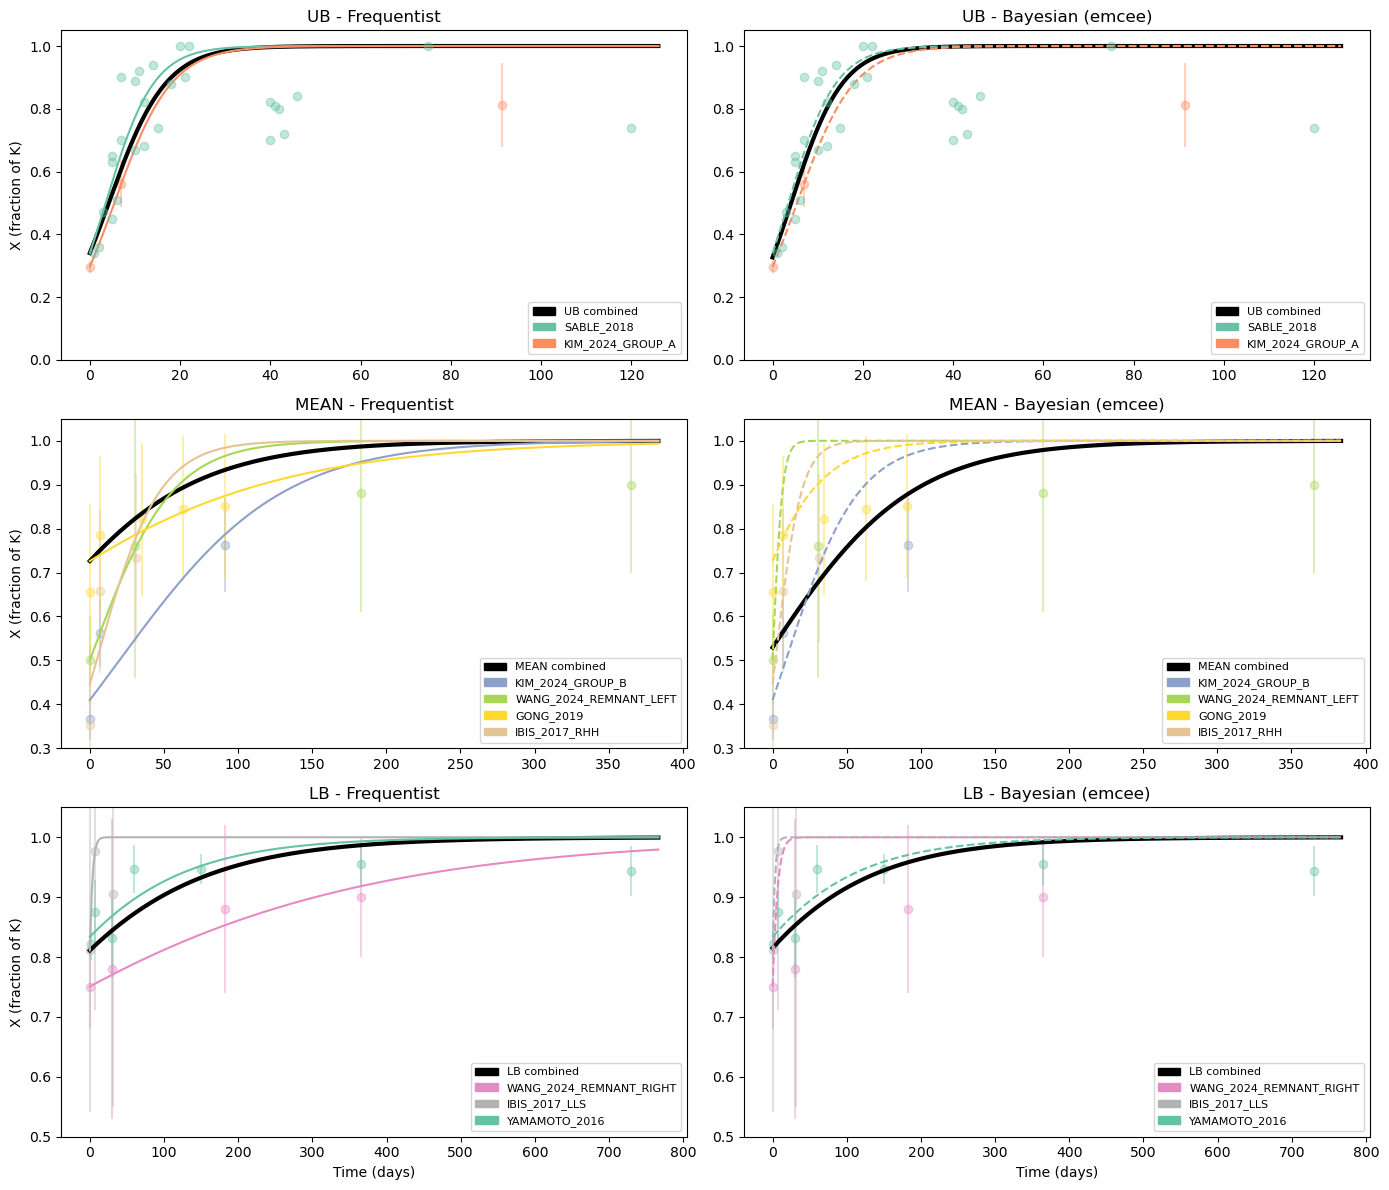

In [72]:
import matplotlib.patches as mpatches
# import seaborn as sns

# ----------------------
# Plotting: 3 rows x 2 cols (left Frequentist, right Bayesian)
# ----------------------
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12), sharex=False, sharey=False)
group_order = ['UB','MEAN','LB']

# consistent color palette for all datasets
all_dnames = list(prepared.keys())
palette = dict(zip(all_dnames, sns.color_palette("Set2", len(all_dnames))))

group_ylims = {'LB':[0.5, 1.05], 'MEAN':[0.3, 1.05], 'UB':[0, 1.05]}

for i, g in enumerate(group_order):
    dnames = groups[g]

    # Frequentist (left)
    ax = axes[i,0]
    if len(dnames)>0 and g in group_freq:
        patches = []
        tt = np.linspace(0, max([prepared[dn]['t'][-1] for dn in dnames])*1.05, 300)

        # combined freq curve
        r_comb = group_freq[g]['r_hat']; x0_comb = group_freq[g]['x0_rep']
        ax.plot(tt, logistic_solution(tt, r_comb, x0_comb, K),
                color="black", linewidth=3, label=f"{g} combined")
        patches.append(mpatches.Patch(color="black", label=f"{g} combined"))

        for dn in dnames:
            ds = prepared[dn]
            col = palette[dn]
            # dataset points (lighter)
            if ds['sigma'] is not None:
                ax.errorbar(ds['t'], ds['x'], yerr=1.96*ds['sigma'], fmt='o',
                            color=col, alpha=0.4, zorder=1)
            else:
                ax.plot(ds['t'], ds['x'], 'o', color=col, alpha=0.4, zorder=3)
            # curve fit
            r_hat = per_dataset_freq[dn]['r_hat']
            x0_hat = per_dataset_freq[dn]['x0_hat']
            ax.plot(tt, logistic_solution(tt, r_hat, x0_hat, K),
                    color=col, linewidth=1.5, zorder=2)
            # legend patch
            patches.append(mpatches.Patch(color=col, label=dn))

        ax.set_title(f"{g} - Frequentist")
        ax.set_ylim(group_ylims[g])
        ax.legend(handles=patches, fontsize=8, loc='lower right')

    else:
        ax.text(0.5,0.5,"No data",ha='center',va='center')
        ax.set_title(f"{g} - Frequentist")

    # Bayesian (right)
    ax = axes[i,1]
    if len(dnames)>0 and g in group_bayes:
        patches = []
        tt = np.linspace(0, max([prepared[dn]['t'][-1] for dn in dnames])*1.05, 300)

        # combined bayes curve
        r_b = group_bayes[g]['r_mean']; x0_b = group_bayes[g]['x0_rep']
        ax.plot(tt, logistic_solution(tt, r_b, x0_b, K),
                color="black", linewidth=3, label=f"{g} combined")
        patches.append(mpatches.Patch(color="black", label=f"{g} combined"))

        for dn in dnames:
            ds = prepared[dn]
            col = palette[dn]
            # dataset points (lighter)
            if ds['sigma'] is not None:
                ax.errorbar(ds['t'], ds['x'], yerr=1.96*ds['sigma'], fmt='o',
                            color=col, alpha=0.4, zorder=1)
            else:
                ax.plot(ds['t'], ds['x'], 'o', color=col, alpha=0.4, zorder=3)
            # bayes mean fit
            if dn in per_dataset_bayes:
                r_m = per_dataset_bayes[dn]['r_mean']
                x0_hat = per_dataset_freq[dn]['x0_hat']
                ax.plot(tt, logistic_solution(tt, r_m, x0_hat, K),
                        color=col, linewidth=1.5, linestyle='--', zorder=2)
            # legend patch
            patches.append(mpatches.Patch(color=col, label=dn))

        ax.set_title(f"{g} - Bayesian (emcee)")
        ax.set_ylim(group_ylims[g])
        ax.legend(handles=patches, fontsize=8, loc='lower right')

    else:
        ax.text(0.5,0.5,"No data",ha='center',va='center')
        ax.set_title(f"{g} - Bayesian")
    
for ax in axes[-1,:]:
    ax.set_xlabel("Time (days)")
axes[0,0].set_ylabel("X (fraction of K)")
axes[1,0].set_ylabel("X (fraction of K)")
axes[2,0].set_ylabel("X (fraction of K)")

plt.tight_layout()
plt.show()


## tests

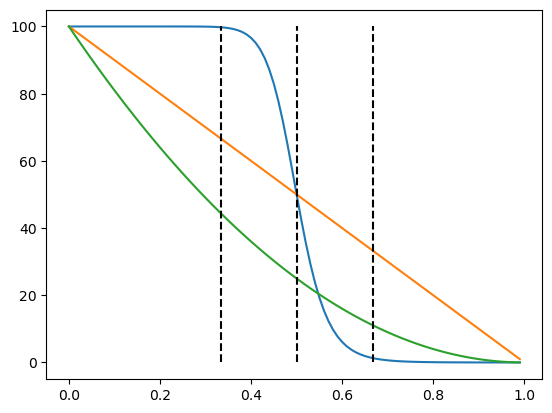

In [8]:
x = np.arange(0,1,0.01)

r = 100
rho_hill = r * (1 / (1 + (x / 0.5)**15))
rho_log = r * (1 - x)
rho_logadj = r * (1 - x)**(1/(1/3)-1)
# y = np.arange()
sns.lineplot(x=x, y=rho_hill)
sns.lineplot(x=x, y=rho_log)
sns.lineplot(x=x, y=rho_logadj)
plt.vlines(x=[1/3, 1/2, 2/3], ymin=0, ymax=r, linestyles='--', colors='k')

In [9]:
(1/(1/3)-1)

2.0

## LSC replication rate $r_s$

In [64]:
r_s_lower = 1e-4

t_doubling = {'AdultLPCs':62, 'FetalLPCs':46, 'BecLPCs':28.5, 'reLPCs':21.6, 'HepLPCs':25.8}
r_s_upper = {}
for i, (k, t) in enumerate(t_doubling.items()):
    r_s_upper[k] = np.log(2) / (t / HOURS_PER_DAY)
r_s_upper

{'AdultLPCs': np.float64(0.2683150376361078),
 'FetalLPCs': np.float64(0.3616420072486671),
 'BecLPCs': np.float64(0.5837028888925855),
 'reLPCs': np.float64(0.7701635339554948),
 'HepLPCs': np.float64(0.644788074939484)}

In [65]:
r_s_mean = st.gmean([1e-4] + [r_s_upper['AdultLPCs'], r_s_upper['reLPCs']])
r_s_mean

np.float64(0.027441593177841117)

In [69]:
r_s_year = np.array([r_s_mean, r_s_lower, r_s_upper['reLPCs']]) * DAYS_PER_YEAR
r_s_year

array([1.00228361e+01, 3.65242500e-02, 2.81296455e+02])

## LSC division types

We model stem cell division probabilities via a softmax over linear utilities.  

This part builds the linear-softmax model for LSC division types, fits
the utilities to three calibration points, and plots the
resulting probability surfaces:

$$f_{ss}(s,x), \quad f_{xx}(s,x), \quad f_{xs}(s,x)$$

Let
$$s = S/Q \text{ and } x = X/K \text{ (both normalized to [0,1])}.$$

Utilities:
\begin{equation*}
U_{ss}(s,x) = a_1 + b_1 s + c_1 x, \quad U_{xx}(s,x) = a_2 + b_2 s + c_2 x, \quad U_{xs}(s,x) = 0 \text{ (baseline)}.
\end{equation*}
Probabilities:
\begin{align*}
 f_{ss}(s,x) &= \frac{e^{U_{ss}(s,x)}}{e^{U_{ss}(s,x)} + e^{U_{xx}(s,x)} + e^{U_{xs}}} = \frac{e^{U_{ss}(s,x)}}{e^{U_{ss}(s,x)} + e^{U_{xx}(s,x)} + 1}, \\
 f_{xx}(s,x) &= \frac{e^{U_{xx}(s,x)}}{e^{U_{ss}(s,x)} + e^{U_{xx}(s,x)} + e^{U_{xs}}} = \frac{e^{U_{xx}(s,x)}}{e^{U_{ss}(s,x)} + e^{U_{xx}(s,x)} + 1}, \\
 f_{xs}(s,x) &= \frac{e^{U_{xs}}}{e^{U_{ss}(s,x)} + e^{U_{xx}(s,x)} + e^{U_{xs}}} = \frac{1}{e^{U_{ss}(s,x)} + e^{U_{xx}(s,x)} + 1}.
\end{align*}
This guarantees $f_{ss}+f_{xx}+f_{xs}=1$.

Calibration points (inferred from Qin et al., 2022):
- Homeostasis (s=1, x=1): (0.1, 0.1, 0.8)
- Severe injury, stem wave (s=1/3, x=1/3): (0.75, 0.1, 0.15)
- Renewal decline, differentiation wave (s=2/3, x=1/3): (0.1, 0.75, 0.15)

  parameter     value
0        a1  3.453878
1        b1 -6.044709
2        c1  0.511390
3        a2  0.431523
4        b2  6.044709
5        c2 -8.555674
s=1.000, x=1.000 → (fss,fxx,fxs)=(0.100,0.100,0.800), target=[0.1 0.1 0.8]
s=0.333, x=0.333 → (fss,fxx,fxs)=(0.750,0.100,0.150), target=[0.75 0.1  0.15]
s=0.667, x=0.333 → (fss,fxx,fxs)=(0.100,0.750,0.150), target=[0.1  0.75 0.15]


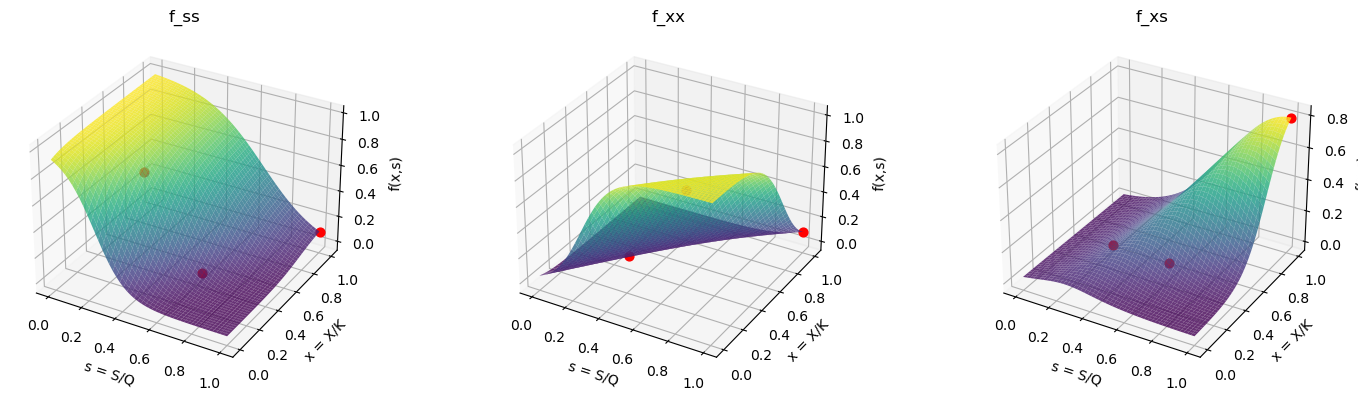

In [ ]:
# Calibration data
states = np.array([
    [1.0, 1.0], # s, x at homeostasis
    [1/3, 1/3], # s, x after injury
    [2/3, 1/3]  # s, x after self-renewal peaked
])
# f_ss, f_xx, f_xs
targets = np.array([
    [0.1, 0.1, 0.8],
    [0.75, 0.1, 0.15],
    [0.1, 0.75, 0.15]
])

# Softmax helper
def softmax_utils(Uss, Uxx):
    exp_ss, exp_xx, exp_xs = np.exp(Uss), np.exp(Uxx), 1.0
    den = exp_ss + exp_xx + exp_xs
    return exp_ss/den, exp_xx/den, exp_xs/den

# Build linear system for log-odds
A_rows, y_vec = [], []
for (s,x), (p_ss, p_xx, p_xs) in zip(states, targets):
    y1 = np.log(p_ss/p_xs)
    y2 = np.log(p_xx/p_xs)
    A_rows.append([1, s, x, 0, 0, 0])
    y_vec.append(y1)
    A_rows.append([0, 0, 0, 1, s, x])
    y_vec.append(y2)

A, y = np.array(A_rows), np.array(y_vec)
params, *_ = np.linalg.lstsq(A, y, rcond=None)
a1,b1,c1,a2,b2,c2 = params

# Save parameters
param_df = pd.DataFrame({
    'parameter': ['a1','b1','c1','a2','b2','c2'],
    'value': params
})
print(param_df)

# Calibration check
for (s,x), targ in zip(states, targets):
    fss, fxx, fxs = softmax_utils(a1+b1*s+c1*x, a2+b2*s+c2*x)
    print(f"s={s:.3f}, x={x:.3f} → (fss,fxx,fxs)=({fss:.3f},{fxx:.3f},{fxs:.3f}), target={targ}")

# Plot surfaces
S, X = np.meshgrid(np.linspace(0,1,50), np.linspace(0,1,50))
Uss = a1 + b1*S + c1*X
Uxx = a2 + b2*S + c2*X
Fss, Fxx, Fxs = softmax_utils(Uss, Uxx)

fig, axes = plt.subplots(1,3,figsize=(15,4),subplot_kw={'projection':'3d'})
for ax, Z, title in zip(axes, [Fss,Fxx,Fxs], ["f_ss","f_xx","f_xs"]):
    ax.plot_surface(S, X, Z, cmap='viridis', alpha=0.8)
    ax.set_xlabel("s = S/Q")
    ax.set_ylabel("x = X/K")
    ax.set_zlabel("f(x,s)")
    ax.set_title(title)
    # Plot calibration points
    for (s,x), (fss,fxx,fxs) in zip(states, targets):
        if title=="f_ss": ax.scatter(s, x, fss, c='r', s=40)
        if title=="f_xx": ax.scatter(s, x, fxx, c='r', s=40)
        if title=="f_xs": ax.scatter(s, x, fxs, c='r', s=40)

fig.tight_layout()
plt.show()

# Lung

## BBC capacity $K$

In [2]:
# Let's assume:
# - The airway surface area (proximal bronchi, both lungs) is around 2000 cm² (published estimates range from 1500–3000 cm²)
# - Basal cells make up roughly 40% of the pseudostratified epithelium in large airways 
# - Epithelial cell density ≈ 10^6 cells/cm² (a reasonable estimate for airway surfaces)

# BBC surface density estimate
total_surface_cm2 = 2000
epithelial_cell_density_per_cm2 = 1e6
basal_fraction = 0.4

# Total BBCs
B_max = total_surface_cm2 * epithelial_cell_density_per_cm2 * basal_fraction

# Confidence range: based on ±25% variation in area and basal fraction
surface_range = [1500, 2500]  # cm²
basal_fraction_range = [0.25, 0.35]

# Bounds
B_min = min(surface_range) * epithelial_cell_density_per_cm2 * min(basal_fraction_range)
B_max_upper = max(surface_range) * epithelial_cell_density_per_cm2 * max(basal_fraction_range)

{
    "B_max_median": B_max,
    "B_max_range": (B_min, B_max_upper),
    "unit": "cells"
}


{'B_max_median': 800000000.0,
 'B_max_range': (375000000.0, 875000000.0),
 'unit': 'cells'}

In [3]:
# Monte-Carlo draws
N = 500_000  # number of MC samples

# --- Input variables ---

# Mercer 1994 morphometry: 
# "Total airway surface area from trachea to bronchioles was 2,471 +/- 320 cm^2" ... "The total number of airway epithelial cells were 10.5 x 10^9 for human"
mercer_area_mean_cm2 = 2471.0
mercer_area_sd_cm2   = 320.0
epi_cells_mean = 10.5e9
# we assume epithelial-cell count uncertainty scales with measured area CV
epi_cells_sd = epi_cells_mean * (mercer_area_sd_cm2 / mercer_area_mean_cm2)

# Basal-cell proportions by airway-size class (from Boers 1998 + review)
# Keys are the diameter bins; values are mean proportion and an estimated SD (uncertainty).
basal_pct = {
    '>=4mm':  (0.31, 0.07),   # "largest (>=4mm) 31% basal" (Boers 1998)
    '2-4mm':  (0.30, 0.07),   # literature-consensus intermediate bin
    '0.5-2mm':(0.10, 0.04),   # small bronchi/large bronchioles range
    '<0.5mm': (0.06, 0.02),   # "smallest (<0.5mm) ~6% basal" (Boers 1998)
}

# Weibel-style geometry parameter:
h = 0.79  # diameter reduction ratio per generation in conducting airways (Weibel/morphometry)

# Length-to-diameter ratio used to convert D -> length per generation (morphometry literature)
LD_mean, LD_sd = 1.46, 0.15  # typical L/D for human conducting airways

# TLV (total lung volume) means & SDs used to scale epithelial counts by sex (PLOS ONE CT-derived TLV)
# We use TLV to scale whole-lung epithelial abundance (assumption: epithelial number scales with lung size)
TLV_ref_mean = 0.5 * (6.2 + 4.7)  # reference mean TLV (average of male & female means) in liters
# Sex-grouped parameters (tracheal length and tracheal volume come from Kamel et al. 2009)
sex_params = {
    'male': {
        'L_mean_mm': 105.1, 'L_sd_mm': 9.8,   # mean tracheal length (mm)
        'V_mean_cm3': 35.6, 'V_sd_cm3': 6.8,  # tracheal luminal volume (cm^3)
        'TLV_mean_L': 6.2, 'TLV_sd_L': 1.2    # mean TLV used for epithelial scaling (L)
    },
    'female': {
        'L_mean_mm': 98.3, 'L_sd_mm': 8.7,
        'V_mean_cm3': 24.7, 'V_sd_cm3': 6.1,
        'TLV_mean_L': 4.7, 'TLV_sd_L': 0.9
    },
    'combined': {  # combined cohort reported in Kamel et al.
        'L_mean_mm': 102.8, 'L_sd_mm': 9.9,
        'V_mean_cm3': 32.0, 'V_sd_cm3': 8.3,
        'TLV_mean_L': TLV_ref_mean, 'TLV_sd_L': 1.05  # synthetic SD for combined TLV
    }
}

# --- Helper function: truncated-normal sampler ---
def trunc_normal_draw(mean, sd, size, lower=None, upper=None):
    """Draw 'size' samples from a truncated normal with given bounds (inclusive).
       If lower is None, set to mean - 4*sd; if upper None, mean + 4*sd.
       Uses scipy.stats.truncnorm parameterization.
    """
    if lower is None:
        lower = mean - 4 * sd
    if upper is None:
        upper = mean + 4 * sd
    a, b = (lower - mean) / sd, (upper - mean) / sd
    return st.truncnorm.rvs(a, b, loc=mean, scale=sd, size=size, random_state=None)

# --- Monte-Carlo draws of uncertain inputs ---
# Draw epithelial cell anchor (combined) from normal (approximate) - ensure positivity via truncation
epi_cells_draw = trunc_normal_draw(epi_cells_mean, epi_cells_sd, N, lower=1e8, upper=1e11)

# Draw basal percentages per class (vector of length N for each class)
basal_draws = {}
for k, (mu, sd) in basal_pct.items():
    basal_draws[k] = np.clip(np.random.normal(mu, sd, N), 0.0, 1.0)  # small Gaussian uncertainty, clipped

# Draw LD_ratio per draw (length-to-diameter)
LD_ratio = np.random.normal(LD_mean, LD_sd, N)

# prepare generation arrays (we model generations 0..24)
gens = np.arange(0, 25)
pow_h = h ** gens            # h^n
branches = 2 ** gens         # 2^n branches per generation (symmetric branching)

# --- Core geometry & area computation per each sex group ---
def compute_for_sex(sex_key):
    """Compute basal cell K distribution for a given sex_key in sex_params.
       Returns arrays of basal cell totals and diagnostics.
    """
    p = sex_params[sex_key]
    # Draw truncated-normal tracheal length (mm) and volume (cm^3) for this sex
    L_mm = trunc_normal_draw(p['L_mean_mm'], p['L_sd_mm'], N, lower=10.0, upper=p['L_mean_mm'] + 4*p['L_sd_mm'])
    V_cm3 = trunc_normal_draw(p['V_mean_cm3'], p['V_sd_cm3'], N, lower=0.1, upper=p['V_mean_cm3'] + 4*p['V_sd_cm3'])
    # Convert length to cm for area calc (L in mm -> cm)
    L_cm = L_mm / 10.0
    # Equivalent circular diameter based on measured lumen volume and length: D = sqrt(4*(V/L)/pi)
    D0_cm = np.sqrt(4.0 * (V_cm3 / L_cm) / np.pi)
    D0_mm = D0_cm * 10.0  # convert back to mm
    # compute generation diameters D_n (N x G)
    D_n = D0_mm[:, None] * pow_h[None, :]        # mm
    D_n_cm = D_n / 10.0                          # cm
    # cylindrical lateral area per branch approximated as: pi * D * length, with length = LD_ratio * D
    area_branch_cm2 = np.pi * LD_ratio[:, None] * (D_n_cm ** 2)  # shape (N, G)
    # total area per generation = area per branch * branch count
    area_gen_total = area_branch_cm2 * branches[None, :]
    # model_total_area is the unscaled sum across generations (varies per draw)
    model_total_area = area_gen_total.sum(axis=1)  # shape (N,)
    # scale factor to enforce Mercer's measured total airway area (preserve relative distribution)
    scale = mercer_area_mean_cm2 / model_total_area
    scaled_area_gen = area_gen_total * scale[:, None]  # scaled so sum per draw == mercer_area_mean_cm2
    # bin generation areas into diameter classes (use D_n in mm)
    mask_ge4   = (D_n >= 4.0)
    mask_2_4   = (D_n >= 2.0) & (D_n < 4.0)
    mask_05_2  = (D_n >= 0.5) & (D_n < 2.0)
    mask_lt05  = (D_n < 0.5)
    area_ge4   = (scaled_area_gen * mask_ge4).sum(axis=1)
    area_2_4   = (scaled_area_gen * mask_2_4).sum(axis=1)
    area_05_2  = (scaled_area_gen * mask_05_2).sum(axis=1)
    area_lt05  = (scaled_area_gen * mask_lt05).sum(axis=1)
    # area fractions per draw (sum to 1 because scaled to Mercer's area)
    area_frac = np.vstack([area_ge4, area_2_4, area_05_2, area_lt05]).T / mercer_area_mean_cm2
    # sample basal fractions per class from draws prepared earlier
    basal_vec = np.vstack([basal_draws['>=4mm'], basal_draws['2-4mm'],
                           basal_draws['0.5-2mm'], basal_draws['<0.5mm']]).T  # shape (N,4)
    # compute area-weighted basal fraction per draw
    f_basal = (area_frac * basal_vec).sum(axis=1)   # shape (N,)
    # sex-scale epithelial cell counts by TLV ratio (assumption: epithelial number scales with TLV)
    TLV_draws = trunc_normal_draw(p['TLV_mean_L'], p['TLV_sd_L'], N,
                                  lower=max(0.5, p['TLV_mean_L'] - 3*p['TLV_sd_L']),
                                  upper=p['TLV_mean_L'] + 4*p['TLV_sd_L'])
    epi_cells_sex = epi_cells_draw * (TLV_draws / TLV_ref_mean)
    # total basal cells per draw
    basal_cells = epi_cells_sex * f_basal
    # diagnostics to inspect model behavior
    diag = {
        'D0_mm_mean': float(D0_mm.mean()),
        'model_area_mean_before_scaling_cm2': float(model_total_area.mean()),
        'scale_mean': float(scale.mean()),
        'f_basal_mean': float(f_basal.mean()),
        'area_frac_means': area_frac.mean(axis=0)
    }
    return basal_cells, diag

# Run for each sex key and collect results
results = {}
diagnostics = {}
for sex in sex_params.keys():
    basal_cells, diag = compute_for_sex(sex)
    results[sex] = basal_cells
    diagnostics[sex] = diag

# --- Summaries ---
def summarize_arr(arr):
    return {'mean': float(arr.mean()), 'median': float(np.median(arr)),
            '2.5%': float(np.percentile(arr, 2.5)), '97.5%': float(np.percentile(arr, 97.5))}

summary_df = pd.DataFrame({sex: summarize_arr(results[sex]) for sex in results}).T
summary_df = summary_df.map(lambda x: f"{x:,.2e}")

summary_df

,mean,median,2.5%,97.5%
male,8.73e+08,8.43e+08,3.75e+08,1.54e+09
female,6.45e+08,6.23e+08,2.70e+08,1.15e+09
combined,7.61e+08,7.35e+08,3.24e+08,1.35e+09


In [4]:
diagnostics

{'male': {'D0_mm_mean': 20.740429416720033,
  'model_area_mean_before_scaling_cm2': 20453.71289507375,
  'scale_mean': 0.12834877440819373,
  'f_basal_mean': 0.07303578606007423,
  'area_frac_means': array([0.01679767, 0.0190362 , 0.10645262, 0.85771351])},
 'female': {'D0_mm_mean': 17.7893186249851,
  'model_area_mean_before_scaling_cm2': 15147.032297419852,
  'scale_mean': 0.1794722440177569,
  'f_basal_mean': 0.0711366299649169,
  'area_frac_means': array([0.01395736, 0.01645363, 0.09223547, 0.87735355])},
 'combined': {'D0_mm_mean': 19.79751125307231,
  'model_area_mean_before_scaling_cm2': 18804.263509406668,
  'scale_mean': 0.14649910653666173,
  'f_basal_mean': 0.07242753639863377,
  'area_frac_means': array([0.01588126, 0.01820355, 0.10194748, 0.86396771])}}

Summary for max_gen=25 (default):
 male   : mean=1.216e+09, median=1.194e+09, 95% CI=(6.791e+08, 1.874e+09)
 female : mean=9.228e+08, median=9.066e+08, 95% CI=(5.194e+08, 1.433e+09)
 all    : mean=1.068e+09, median=1.046e+09, 95% CI=(6.041e+08, 1.645e+09)


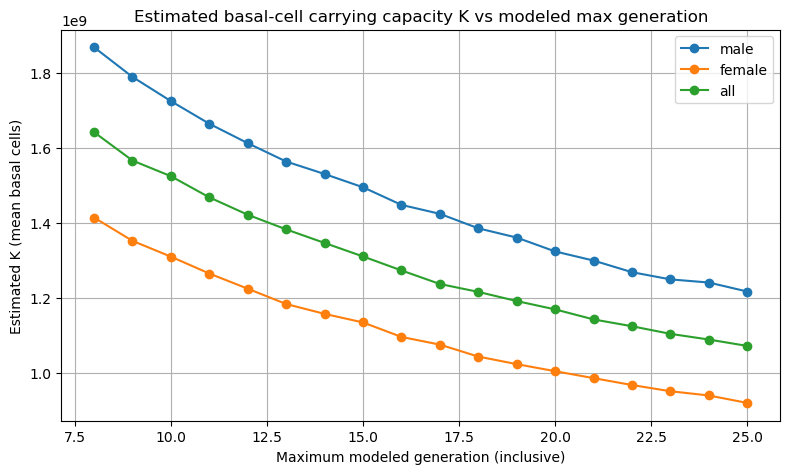

Saved summary CSV to basal_K_vs_gens_summary_final.csv and plot to ./basal_K_vs_gens_plot_final.png

Diagnostics (generation 15):
 male   D0_mean_mm=20.68, model_area_before_scaling_mean=25411.5, scale_mean=0.103
   mean area fractions per gen (first few): [0.0008 0.001  0.0012 0.0015 0.0019 0.0024] ... last: 0.1995
   p_means (per-gen): [0.4        0.31       0.29958333 0.28916667 0.27875    0.26833333
 0.25791667 0.2475     0.23708333 0.22666667 0.21625    0.20583333
 0.19541667 0.185      0.17458333 0.16416667 0.15375    0.14333333
 0.13291667 0.1225     0.11208333 0.10166667 0.09125    0.08083333
 0.07041667 0.06      ]

 female D0_mean_mm=17.81, model_area_before_scaling_mean=18979.8, scale_mean=0.144
   mean area fractions per gen (first few): [0.0008 0.001  0.0012 0.0015 0.0019 0.0024] ... last: 0.1995
   p_means (per-gen): [0.4        0.31       0.29958333 0.28916667 0.27875    0.26833333
 0.25791667 0.2475     0.23708333 0.22666667 0.21625    0.20583333
 0.19541667 0.185      

<Figure size 640x480 with 0 Axes>

In [70]:
# Basal-cell carrying-capacity pipeline (single Jupyter cell)
# Reproducible, vectorized, Monte-Carlo uncertainty propagation
# Paste this whole cell into a Jupyter notebook and run.

import numpy as np
import pandas as pd
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
np.random.seed(42)

# ----------------------- PAPER-RETRIEVED ANCHORS -----------------------
# Mercer 1994 morphometry anchor:
mercer_area_mean_cm2 = 2471.0        # "Total airway surface area ... 2,471 +/- 320 cm^2" (Mercer et al.)
mercer_area_sd_cm2   = 320.0

# Total airway epithelial cells (Mercer): 10.5 x 10^9
epi_cells_mean = 10.5e9              # Mercer: "The total number of airway epithelial cells were 10.5 x 10^9 for human"
# Assume epithelial-cell-count uncertainty scales with Mercer area CV
epi_cells_sd = epi_cells_mean * (mercer_area_sd_cm2 / mercer_area_mean_cm2)

# Kamel et al. (CT) tracheal measurements (means ± SD) - sex-stratified
# (used as volume/length anchor to compute D0 = sqrt(4*(V/L)/pi))
sex_params = {
    'male': {
        'L_mean_mm': 105.1, 'L_sd_mm': 9.8,    # tracheal length (mm) - Kamel 2009
        'V_mean_cm3': 35.6, 'V_sd_cm3': 6.8,   # tracheal lumen volume (cm^3) - Kamel 2009
        'TLV_mean_L': 6.2, 'TLV_sd_L': 1.2     # mean TLV (L) used to scale epithelial totals (population CT)
    },
    'female': {
        'L_mean_mm': 98.3, 'L_sd_mm': 8.7,
        'V_mean_cm3': 24.7, 'V_sd_cm3': 6.1,
        'TLV_mean_L': 4.7, 'TLV_sd_L': 0.9
    },
    'all': {  # combined cohort anchors (Kamel "all" column)
        'L_mean_mm': 102.8, 'L_sd_mm': 9.9,
        'V_mean_cm3': 32.0,  'V_sd_cm3': 8.3,
        'TLV_mean_L': 0.5*(6.2 + 4.7), 'TLV_sd_L': 1.05
    }
}
TLV_ref_mean = 0.5*(6.2 + 4.7)  # reference TLV used for scaling epithelial counts

# Weibel-style geometry & morphometry inputs
h = 0.79                    # diameter reduction factor per generation (Weibel style)
LD_mean, LD_sd = 1.46, 0.15 # length-to-diameter ratio mean and SD (morphometry literature)

# Basal fraction anchoring:
# generation 0 (trachea): use murine trachea value as requested (Hogan et al., PMC4518462)
p0_mean, p0_sd = 0.40, 0.05    # tracheal basal fraction mean ± sd (murine data)
# generation 1 baseline (proximal bronchi) from human histology (Boers 1998)
p1_mean = 0.31                 # "largest conducting airways (>=4mm) 31% basal" (Boers)
# distal generation 15 (terminal bronchiole anchor)
pN_mean = 0.06                 # "smallest (<0.5 mm) ~6% basal" (Boers)
# per-generation sd for gens 1..N
p_gen_sd = 0.03

# Monte-Carlo settings
N_draws = 8000   # MC draws (adjust if you want smoother tails; larger -> more memory/time)
max_gen_default = 15   # default terminal generation (we stop at generation 15)
# -----------------------------------------------------------------------

# helper: truncated-normal sampler wrapper
def trunc_normal_draw(mean, sd, size, lower=None, upper=None):
    """Truncated-normal draws using scipy.stats.truncnorm parameterization."""
    # default truncation to ±4 sd if bounds not provided
    if lower is None:
        lower = mean - 4*sd
    if upper is None:
        upper = mean + 4*sd
    a, b = (lower - mean) / sd, (upper - mean) / sd
    return truncnorm.rvs(a, b, loc=mean, scale=sd, size=size)

# Vectorized compute function: compute K distributions for a chosen max_gen
def compute_K_distribution(max_gen=max_gen_default, N=N_draws,
                           p0=p0_mean, p0_sd_in=p0_sd, p1=p1_mean, pN=pN_mean, p_sd=p_gen_sd):
    """
    Compute Monte-Carlo sampled distributions of K (basal cell counts) per sex,
    given:
      - max_gen: inclusive max generation index (0..max_gen)
      - N: number of MC draws
      - p0: basal fraction at generation 0 (trachea)
      - p1: basal fraction at generation 1
      - pN: basal fraction at generation max_gen
    Returns:
      results: dict mapping sex -> ndarray shape (N,) with basal-cell counts samples
      diagnostics: dict of diagnostic arrays / means (D0 mean, scale mean, area fractions etc.)
    """
    gens = np.arange(0, max_gen+1)
    G = len(gens)
    pow_h = h ** gens             # shape (G,)
    branches = (2 ** gens).astype(float)

    # draw common anchors
    epi_cells_draw = trunc_normal_draw(epi_cells_mean, epi_cells_sd, N, lower=1e8, upper=1e11)
    LD_ratio = np.random.normal(LD_mean, LD_sd, N)  # length-to-diameter per draw

    # build per-generation basal means: p0 at gen 0, linear interpolation for gens 1..max_gen
    p_means = np.empty(G)
    p_sds   = np.empty(G)
    p_means[0] = p0
    p_sds[0]   = p0_sd_in
    if G > 1:
        # linear interpolation for gens 1..max_gen: p1 at n=1, pN at n=max_gen
        p_means[1:] = p1 + (pN - p1) * ((gens[1:] - 1) / float(max_gen - 1))
        p_sds[1:]   = p_sd

    results = {}
    diagnostics = {}

    # loop sexes (only 3 keys) but heavy work is vectorized internally
    for sex_key, params in sex_params.items():
        # truncated draws for tracheal length and volume for this sex
        L_mm = trunc_normal_draw(params['L_mean_mm'], params['L_sd_mm'], N,
                                 lower=10.0, upper=params['L_mean_mm'] + 4*params['L_sd_mm'])
        V_cm3 = trunc_normal_draw(params['V_mean_cm3'], params['V_sd_cm3'], N,
                                  lower=0.1, upper=params['V_mean_cm3'] + 4*params['V_sd_cm3'])
        # convert length to cm
        L_cm = L_mm / 10.0
        # equivalent circular diameter from volume/length
        D0_cm = np.sqrt(4.0 * (V_cm3 / L_cm) / np.pi)    # cm
        D0_mm = D0_cm * 10.0                              # mm

        # generation diameters (broadcasted): shape (N, G)
        D_n = D0_mm[:, None] * pow_h[None, :]             # mm
        D_n_cm = D_n / 10.0                               # cm

        # lateral area per branch approximation: pi * D * length, with length = LD_ratio * D
        area_branch_cm2 = np.pi * LD_ratio[:, None] * (D_n_cm ** 2)   # (N,G)
        # total area per generation = area per branch * branch count
        area_gen_total = area_branch_cm2 * branches[None, :]          # (N,G)
        # model total area for draw i
        model_total_area = area_gen_total.sum(axis=1)                 # (N,)

        # empirical scaling s that matches Mercer total measured area (scalar per draw)
        scale = mercer_area_mean_cm2 / model_total_area               # (N,)
        scaled_area_gen = area_gen_total * scale[:, None]            # (N,G); sums to mercer_area_mean_cm2

        # draw per-generation basal fractions using truncated normals (N x G)
        p_draws = np.empty((N, G))
        for j in range(G):
            p_draws[:, j] = trunc_normal_draw(p_means[j], p_sds[j], N, lower=0.0, upper=1.0)

        # area-weighted basal fraction per draw: sum_j (A'_j * p_j) / A_meas
        f_basal = (scaled_area_gen * p_draws).sum(axis=1) / mercer_area_mean_cm2   # (N,)

        # scale epithelial count by sex TLV draws
        TLV_draws = trunc_normal_draw(params['TLV_mean_L'], params['TLV_sd_L'], N,
                                      lower=max(0.5, params['TLV_mean_L'] - 3*params['TLV_sd_L']),
                                      upper=params['TLV_mean_L'] + 4*params['TLV_sd_L'])
        epi_cells_sex = epi_cells_draw * (TLV_draws / TLV_ref_mean)

        # basal cells per draw
        basal_cells = epi_cells_sex * f_basal     # (N,)

        # store
        results[sex_key] = basal_cells
        diagnostics[sex_key] = {
            'D0_mm_mean': float(D0_mm.mean()),
            'model_area_mean_before_scaling_cm2': float(model_total_area.mean()),
            'scale_mean': float(scale.mean()),
            'f_basal_mean': float(f_basal.mean()),
            'area_frac_means': (scaled_area_gen.mean(axis=0) / mercer_area_mean_cm2),
            'p_means': p_means.copy()
        }

    return results, diagnostics

# ----------------------- RUN: compute K for default max_gen=25 -----------------------
results25, diag25 = compute_K_distribution(max_gen=25, N=N_draws)

# Summaries for generation-15 run
def summarize_arr(arr):
    return {
        'mean': float(arr.mean()),
        'median': float(np.median(arr)),
        '2.5%': float(np.percentile(arr, 2.5)),
        '97.5%': float(np.percentile(arr, 97.5))
    }

summary25 = {sex: summarize_arr(results25[sex]) for sex in results25}
print("Summary for max_gen=25 (default):")
for sex, s in summary25.items():
    print(f" {sex:6s} : mean={s['mean']:.3e}, median={s['median']:.3e}, 95% CI=({s['2.5%']:.3e}, {s['97.5%']:.3e})")

# ----------------------- SENSITIVITY: sweep max_gen and plot K(mean) vs max_gen -----------------------
max_gen_values = list(range(8, 26))   # sweep from 8 to 24 inclusive
summary_records = []
for mg in max_gen_values:
    res, dg = compute_K_distribution(max_gen=mg, N=5000)  # lower N for sweep to conserve time
    for sex in res:
        arr = res[sex]
        summary_records.append({
            'max_gen': mg,
            'sex': sex,
            'mean': float(arr.mean()),
            'median': float(np.median(arr)),
            'p2.5': float(np.percentile(arr, 2.5)),
            'p97.5': float(np.percentile(arr, 97.5))
        })

summary_df = pd.DataFrame(summary_records)
pivot_mean = summary_df.pivot(index='max_gen', columns='sex', values='mean')

# Plot mean K vs modeled maximum generation
plt.figure(figsize=(8,5))
for sex in ['male', 'female', 'all']:
    plt.plot(pivot_mean.index, pivot_mean[sex], marker='o', label=sex)
plt.xlabel('Maximum modeled generation (inclusive)')
plt.ylabel('Estimated K (mean basal cells)')
plt.title('Estimated basal-cell carrying capacity K vs modeled max generation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save CSV and simple figure
csv_path = 'basal_K_vs_gens_summary_final.csv'
plt.savefig('basal_K_vs_gens_plot_final.png', dpi=150)
summary_df.to_csv(csv_path, index=False)
print(f"Saved summary CSV to {csv_path} and plot to ./basal_K_vs_gens_plot_final.png")

# Also expose the detailed generation-15 diagnostics (area fractions and p_means)
print("\nDiagnostics (generation 15):")
for sex, d in diag25.items():
    print(f" {sex:6s} D0_mean_mm={d['D0_mm_mean']:.2f}, model_area_before_scaling_mean={d['model_area_mean_before_scaling_cm2']:.1f}, scale_mean={d['scale_mean']:.3f}")
    print(f"   mean area fractions per gen (first few): {d['area_frac_means'][:6].round(4)} ... last: {d['area_frac_means'][-1]:.4f}")
    print(f"   p_means (per-gen): {d['p_means']}\n")


Summary table (saved to K_summary_by_sex_and_model.csv):
     sex k_variant mean_total_basal   CI_2.5  CI_97.5
combined  constant         1.31e+09 7.49e+08 1.98e+09
combined piecewise         1.03e+09 5.73e+08 1.60e+09
    male  constant         1.49e+09 8.51e+08 2.25e+09
    male piecewise         1.17e+09 6.50e+08 1.82e+09
  female  constant         1.13e+09 6.48e+08 1.70e+09
  female piecewise         8.86e+08 4.96e+08 1.37e+09

Per-generation table (combined, piecewise) saved to per_gen_basal_combined_piecewise.csv
Plots saved: K_comparison_bar.png and per_gen_piecewise.png


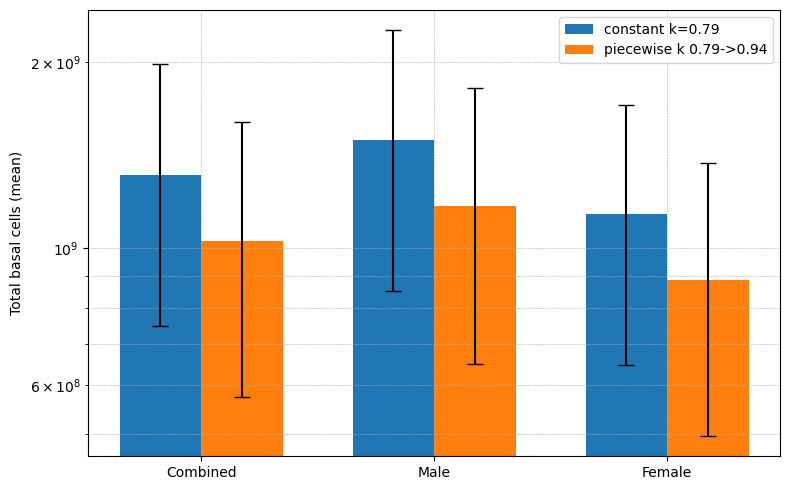

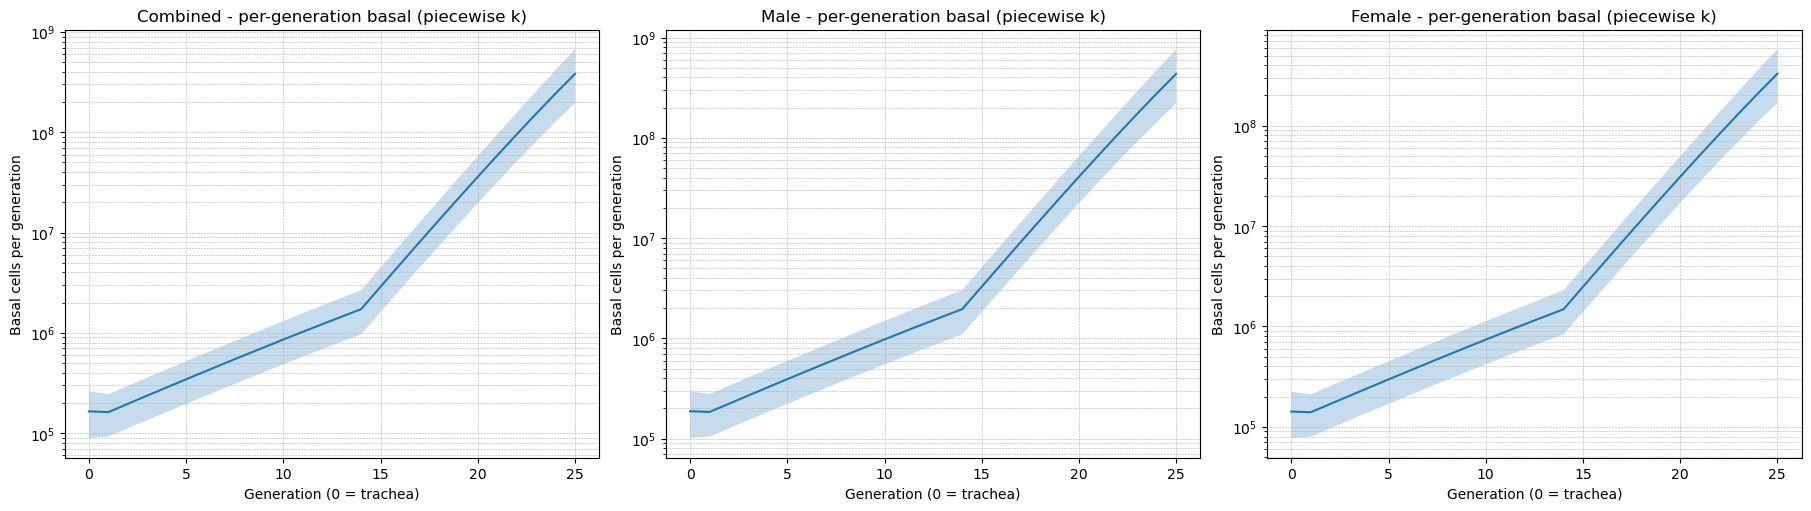

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
from scipy.stats import truncnorm

# -------------------- Anchors / Inputs --------------------
# Mercer et al. anchors (paper-provided)
mercer_area_mean_cm2 = 2471.0
mercer_area_sd_cm2   = 320.0
epi_cells_mean = 10.5e9
# scale epi_cells sd with Mercer area CV
epi_cells_sd = epi_cells_mean * (mercer_area_sd_cm2 / mercer_area_mean_cm2)

# Sex-stratified geometry anchors (Kamel et al. CT)
sex_params = {
    'male': {
        'L_mean_mm': 105.1, 'L_sd_mm': 9.8,
        'V_mean_cm3': 35.6, 'V_sd_cm3': 6.8,
        'TLV_mean_L': 6.2, 'TLV_sd_L': 1.2
    },
    'female': {
        'L_mean_mm': 98.3, 'L_sd_mm': 8.7,
        'V_mean_cm3': 24.7, 'V_sd_cm3': 6.1,
        'TLV_mean_L': 4.7, 'TLV_sd_L': 0.9
    },
    'combined': {
        'L_mean_mm': 102.8, 'L_sd_mm': 9.9,
        'V_mean_cm3': 32.0, 'V_sd_cm3': 8.3,
        'TLV_mean_L': 0.5*(6.2 + 4.7), 'TLV_sd_L': 1.05
    }
}
TLV_ref_mean = 0.5*(6.2 + 4.7)

# Weibel-style and basal fraction anchors
k_before = 0.79
k_after  = 0.94  # piecewise change starting at gen 15
LD_mean, LD_sd = 1.46, 0.15
p0_mean, p0_sd = 0.40, 0.05    # tracheal basal fraction (murine anchor used per user)
p1_mean = 0.31
pN_mean = 0.06
p_gen_sd = 0.03

G_max = 25
gens = np.arange(0, G_max + 1)

# Monte Carlo settings
N_SAMPLES = 500000
SEED_BASE = 42

# -------------------- helpers: truncated normal sampling --------------------
def truncnorm_a_b(lower, upper, loc, scale):
    """Return (a, b) parameters for scipy.stats.truncnorm given bounds, loc, scale."""
    a, b = (lower - loc) / scale, (upper - loc) / scale
    return a, b

def sample_truncnorm(loc, scale, lower, upper, size, random_state=None):
    """Vectorized truncated normal sampling wrapper using scipy.stats.truncnorm.rvs."""
    if scale == 0:
        return np.full(size, loc)
    a, b = truncnorm_a_b(lower, upper, loc, scale)
    return truncnorm.rvs(a, b, loc=loc, scale=scale, size=size, random_state=random_state)

# -------------------- main simulation function (vectorized) --------------------
def run_pipeline(sex='combined', n_samples=N_SAMPLES, k_variant='constant', seed=0):
    rng = np.random.default_rng(seed)

    # truncated draws for Mercer area and epithelial counts
    mercer_area = sample_truncnorm(mercer_area_mean_cm2, mercer_area_sd_cm2, lower=500.0, upper=1e5, size=n_samples, random_state=rng)
    epi_cells = sample_truncnorm(epi_cells_mean, epi_cells_sd, lower=1e7, upper=1e12, size=n_samples, random_state=rng)

    # sex-specific geometry
    sp = sex_params[sex]
    L_mm = sample_truncnorm(sp['L_mean_mm'], sp['L_sd_mm'], lower=10.0, upper=300.0, size=n_samples, random_state=rng)
    L_cm = L_mm / 10.0
    V_cm3 = sample_truncnorm(sp['V_mean_cm3'], sp['V_sd_cm3'], lower=1.0, upper=500.0, size=n_samples, random_state=rng)
    TLV_L = sample_truncnorm(sp['TLV_mean_L'], sp['TLV_sd_L'], lower=0.5, upper=12.0, size=n_samples, random_state=rng)

    # D0 from tracheal lumen geometry
    D0_cm = np.sqrt(4.0 * (V_cm3 / L_cm) / pi)

    # LD per sample
    LD = sample_truncnorm(LD_mean, LD_sd, lower=0.2, upper=5.0, size=n_samples, random_state=rng)

    # epithelial counts scaled by subject TLV relative to reference (sex-specific density coupling)
    epi_cells_scaled = epi_cells * (TLV_L / TLV_ref_mean)

    # build per-generation diameters
    if k_variant == 'constant':
        Dg = D0_cm[:, None] * (k_before ** gens)[None, :]
    elif k_variant == 'piecewise':
        g_counts_before = np.minimum(gens, 14)
        g_counts_after = np.maximum(gens - 14, 0)
        Dg = D0_cm[:, None] * (k_before ** g_counts_before[None, :]) * (k_after ** g_counts_after[None, :])
    else:
        raise ValueError("k_variant must be 'constant' or 'piecewise'")

    # lengths and raw areas per airway
    Lg = LD[:, None] * Dg  # airway length per airway (cm)
    Ag_per_airway = pi * Dg * Lg  # lateral area per airway (cm^2)
    total_Ag_raw = Ag_per_airway * (2 ** gens)[None, :]  # raw total area per gen (cm^2)
    A_model_total = np.sum(total_Ag_raw, axis=1)

    # scalar to enforce Mercer's measured total area
    scalar = mercer_area / A_model_total
    scalar = scalar[:, None]
    total_area_g = total_Ag_raw * scalar  # scaled areas per generation

    # epithelial cell density (cells/cm^2) for each sample
    cells_per_cm2 = epi_cells_scaled / mercer_area

    # basal fraction p_g: gen0 sampled; gens 1..G linear interpolation between p1 and pN
    linear_values = np.zeros_like(gens, dtype=float)
    linear_values[0] = np.nan
    linear_values[1:] = p1_mean + (pN_mean - p1_mean) * (gens[1:] - 1) / (G_max - 1)
    p0 = sample_truncnorm(p0_mean, p0_sd, lower=0.0, upper=1.0, size=n_samples, random_state=rng)
    p_base = np.tile(linear_values[None, :], (n_samples, 1))
    p_base[:, 0] = p0

    # per-generation noise (truncated so stays in [0,1])
    noise = truncnorm.rvs(*truncnorm_a_b(0 - 0.0, 1 - 0.0, loc=0.0, scale=p_gen_sd), loc=0.0, scale=p_gen_sd, size=(n_samples, gens.size), random_state=rng)
    p_g = p_base + noise
    p_g = np.clip(p_g, 0.0, 1.0)  # numerical safety

    # basal counts per generation and totals
    basal_cells_g = total_area_g * cells_per_cm2[:, None] * p_g
    basal_total = np.sum(basal_cells_g, axis=1)
    basal_cumulative = np.cumsum(basal_cells_g, axis=1)

    # summary statistics
    summary = {
        'mean_total_basal': np.mean(basal_total),
        'median_total_basal': np.median(basal_total),
        'ci_2.5': np.percentile(basal_total, 2.5),
        'ci_97.5': np.percentile(basal_total, 97.5),
        'per_gen_mean': np.mean(basal_cells_g, axis=0),
        'per_gen_ci_lower': np.percentile(basal_cells_g, 2.5, axis=0),
        'per_gen_ci_upper': np.percentile(basal_cells_g, 97.5, axis=0),
        'gens': gens
    }

    return {
        'summary': summary,
        'basal_total_samples': basal_total,
        'basal_cumulative': basal_cumulative,
        'basal_cells_g': basal_cells_g,
        'total_area_g': total_area_g,
        'cells_per_cm2': cells_per_cm2,
        'p_g': p_g,
        'Dg': Dg,
        'Lg': Lg,
        'scalar': scalar
    }

# -------------------- run for sexes and both variants --------------------
results = {}
for sex in ['combined', 'male', 'female']:
    results[(sex, 'constant')] = run_pipeline(sex=sex, n_samples=N_SAMPLES, k_variant='constant', seed=SEED_BASE + hash(sex) % 1000)
    results[(sex, 'piecewise')] = run_pipeline(sex=sex, n_samples=N_SAMPLES, k_variant='piecewise', seed=SEED_BASE + 1000 + hash(sex) % 1000)

# -------------------- assemble summary table --------------------
rows = []
for (sex, kv), out in results.items():
    s = out['summary']
    rows.append({
        'sex': sex,
        'k_variant': kv,
        'mean_total_basal': s['mean_total_basal'],
        'CI_2.5': s['ci_2.5'],
        'CI_97.5': s['ci_97.5']
    })

df_summary = pd.DataFrame(rows)
# format for readability
for c in ['mean_total_basal','CI_2.5','CI_97.5']:
    df_summary[c] = df_summary[c].map(lambda x: f"{x:,.2e}")

# -------------------- plots --------------------
# 1) Bar chart: K (mean) for both variants by sex with error bars
fig1, ax1 = plt.subplots(figsize=(8,5))
bar_width = 0.35
sex_order = ['combined','male','female']
inds = np.arange(len(sex_order))
means_const = [results[(s,'constant')]['summary']['mean_total_basal'] for s in sex_order]
means_pw = [results[(s,'piecewise')]['summary']['mean_total_basal'] for s in sex_order]
ci_lo_const = [results[(s,'constant')]['summary']['mean_total_basal'] - results[(s,'constant')]['summary']['ci_2.5'] for s in sex_order]
ci_hi_const = [results[(s,'constant')]['summary']['ci_97.5'] - results[(s,'constant')]['summary']['mean_total_basal'] for s in sex_order]
ci_lo_pw = [results[(s,'piecewise')]['summary']['mean_total_basal'] - results[(s,'piecewise')]['summary']['ci_2.5'] for s in sex_order]
ci_hi_pw = [results[(s,'piecewise')]['summary']['ci_97.5'] - results[(s,'piecewise')]['summary']['mean_total_basal'] for s in sex_order]

ax1.bar(inds - bar_width/2, means_const, bar_width, label='constant k=0.79', yerr=[ci_lo_const, ci_hi_const], capsize=6)
ax1.bar(inds + bar_width/2, means_pw, bar_width, label='piecewise k 0.79->0.94', yerr=[ci_lo_pw, ci_hi_pw], capsize=6)
ax1.set_xticks(inds)
ax1.set_xticklabels([s.capitalize() for s in sex_order])
ax1.set_ylabel('Total basal cells (mean)')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, which='both', linestyle='--', linewidth=0.4)
fig1.tight_layout()
fig1.savefig('K_comparison_bar.png', dpi=200)

# 2) Per-generation plot only for the piecewise model (three subplots: combined, male, female)
fig2, axes = plt.subplots(1, 3, figsize=(18,5), constrained_layout=True)
for ax, sex in zip(axes, sex_order):
    out = results[(sex, 'piecewise')]
    gens = out['summary']['gens']
    mean_per_gen = out['summary']['per_gen_mean']
    lower = out['summary']['per_gen_ci_lower']
    upper = out['summary']['per_gen_ci_upper']

    ax.plot(gens, mean_per_gen, linewidth=1.5)
    ax.fill_between(gens, lower, upper, alpha=0.25)
    ax.set_yscale('log')
    ax.set_xlabel('Generation (0 = trachea)')
    ax.set_title(f'{sex.capitalize()} - per-generation basal (piecewise k)')
    ax.set_ylabel('Basal cells per generation')
    ax.grid(True, which='both', linestyle='--', linewidth=0.4)

fig2.savefig('per_gen_piecewise.png', dpi=200)

# 3) save per-gen numeric table for piecewise combined
per_gen_table = pd.DataFrame({
    'gen': results[('combined','piecewise')]['summary']['gens'],
    'mean_basal': results[('combined','piecewise')]['summary']['per_gen_mean'],
    'ci_lower': results[('combined','piecewise')]['summary']['per_gen_ci_lower'],
    'ci_upper': results[('combined','piecewise')]['summary']['per_gen_ci_upper']
})
per_gen_table.to_csv('per_gen_basal_combined_piecewise.csv', index=False)

# 4) save summary
df_summary.to_csv('K_summary_by_sex_and_model.csv', index=False)

# Print short textual summaries
print('Summary table (saved to K_summary_by_sex_and_model.csv):')
print(df_summary.to_string(index=False))
print('\nPer-generation table (combined, piecewise) saved to per_gen_basal_combined_piecewise.csv')
print('Plots saved: K_comparison_bar.png and per_gen_piecewise.png')


/tmp/ipykernel_316236/768187125.py:179: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_display[['mean_total_basal','median_total_basal','CI_2.5','CI_97.5']] = df_display[['mean_total_basal','median_total_basal','CI_2.5','CI_97.5']].applymap(lambda x: f"{x:,.2e}")


done


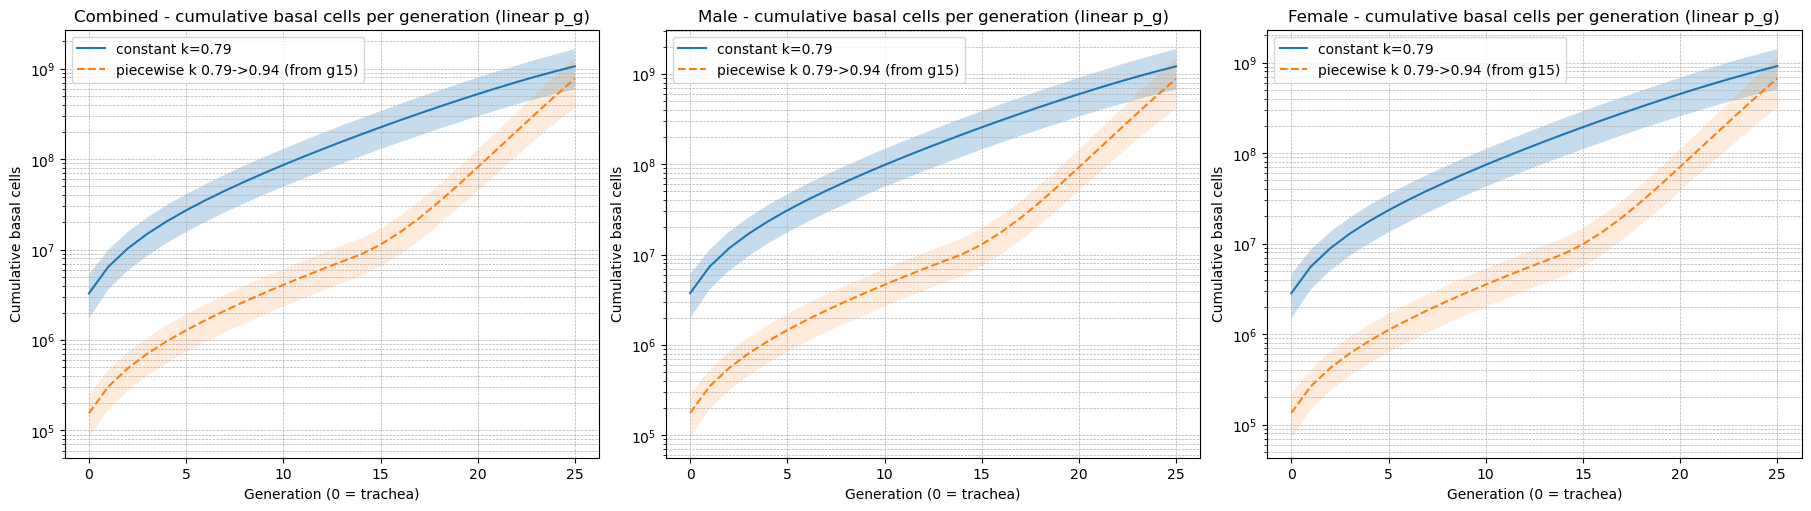

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi, sqrt
import io, base64
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# --------------------------- Anchors (user-provided) ---------------------------
mercer_area_mean_cm2 = 2471.0
mercer_area_sd_cm2   = 320.0
epi_cells_mean = 10.5e9
# epi_cells_sd scales with Mercer area CV
epi_cells_sd = epi_cells_mean * (mercer_area_sd_cm2 / mercer_area_mean_cm2)

sex_params = {
    'male': {
        'L_mean_mm': 105.1, 'L_sd_mm': 9.8,
        'V_mean_cm3': 35.6, 'V_sd_cm3': 6.8,
        'TLV_mean_L': 6.2, 'TLV_sd_L': 1.2
    },
    'female': {
        'L_mean_mm': 98.3, 'L_sd_mm': 8.7,
        'V_mean_cm3': 24.7, 'V_sd_cm3': 6.1,
        'TLV_mean_L': 4.7, 'TLV_sd_L': 0.9
    },
    'combined': { 
        'L_mean_mm': 102.8, 'L_sd_mm': 9.9,
        'V_mean_cm3': 32.0,  'V_sd_cm3': 8.3,
        'TLV_mean_L': 0.5*(6.2 + 4.7), 'TLV_sd_L': 1.05
    }
}
TLV_ref_mean = 0.5*(6.2 + 4.7)

k_before = 0.79
k_after  = 0.94
LD_mean, LD_sd = 1.46, 0.15

p0_mean, p0_sd = 0.40, 0.05
p1_mean = 0.31
pN_mean = 0.06
p_gen_sd = 0.03

G_max = 25
gens = np.arange(0, G_max + 1)
n_g = 2 ** gens

# --------------------------- helper: truncated normal sampling ---------------------------
def truncnorm_sample(rng, mean, sd, lower, upper, size):
    """Truncated normal sampling via rejection sampling. Returns array of shape (size,)."""
    if sd == 0:
        return np.full(size, mean)
    samples = rng.normal(mean, sd, size=size)
    mask = (samples < lower) | (samples > upper)
    # Iteratively resample where out-of-bounds
    while mask.any():
        ns = mask.sum()
        samples[mask] = rng.normal(mean, sd, size=ns)
        mask = (samples < lower) | (samples > upper)
    return samples

# --------------------------- Monte Carlo function (vectorized) ---------------------------
def run_sim_trunc(sex='combined', n_samples=20000, k_variant='constant', seed=12345):
    rng = np.random.default_rng(seed)
    # Truncated samples for mercer area and epi_cells (positive)
    mercer_area = truncnorm_sample(rng, mercer_area_mean_cm2, mercer_area_sd_cm2, lower=500.0, upper=1e5, size=n_samples)
    epi_cells = truncnorm_sample(rng, epi_cells_mean, epi_cells_sd, lower=1e7, upper=1e12, size=n_samples)
    
    sp = sex_params[sex]
    L_mm = truncnorm_sample(rng, sp['L_mean_mm'], sp['L_sd_mm'], lower=10.0, upper=300.0, size=n_samples)
    L_cm = L_mm / 10.0
    V_cm3 = truncnorm_sample(rng, sp['V_mean_cm3'], sp['V_sd_cm3'], lower=1.0, upper=500.0, size=n_samples)
    TLV_L = truncnorm_sample(rng, sp['TLV_mean_L'], sp['TLV_sd_L'], lower=0.5, upper=12.0, size=n_samples)
    
    # D0
    D0_cm = np.sqrt(4.0 * (V_cm3 / L_cm) / pi)
    
    # LD
    LD = truncnorm_sample(rng, LD_mean, LD_sd, lower=0.2, upper=5.0, size=n_samples)
    
    # epi_cells scaled by TLV relative to ref
    epi_cells_scaled = epi_cells * (TLV_L / TLV_ref_mean)
    
    # diameter per generation
    if k_variant == 'constant':
        Dg = D0_cm[:, None] * (k_before ** gens)[None, :]
    else:
        g_counts_before = np.minimum(gens, 14)
        g_counts_after = np.maximum(gens - 14, 0)
        Dg = D0_cm[:, None] * (k_before ** g_counts_before[None, :]) * (k_after ** g_counts_after[None, :])
    
    # length per airway and raw area per airway
    Lg = LD[:, None] * Dg  # cm
    Ag_per_airway = pi * Dg * Lg  # cm^2
    total_Ag_raw = Ag_per_airway * n_g[None, :]  # cm^2 per gen for each sample
    A_model_total = np.sum(total_Ag_raw, axis=1)
    
    # scalar to enforce measured Mercer area
    scalar = mercer_area / A_model_total
    scalar = scalar[:, None]  # broadcast
    
    # scaled areas per gen
    total_area_g = total_Ag_raw * scalar  # now sum across gens equals mercer_area per sample
    
    # cells per cm2 based on epi_cells_scaled and mercer_area (consistent)
    cells_per_cm2 = epi_cells_scaled / mercer_area
    
    # basal fraction p_g: linear interpolation for g>=1; g=0 uses sampled p0
    # linear for g>=1: p1 at g=1, pN at g=25
    linear_g = np.zeros_like(gens, dtype=float)
    linear_g[0] = np.nan  # placeholder
    linear_g[1:] = p1_mean + (pN_mean - p1_mean) * (gens[1:] - 1) / (G_max - 1)
    # Expand to samples and set gen0 = sampled p0 (truncated between 0 and 1)
    p0 = truncnorm_sample(rng, p0_mean, p0_sd, lower=0.0, upper=1.0, size=n_samples)
    p_base = np.tile(linear_g[None, :], (n_samples, 1))
    p_base[:, 0] = p0
    
    # add per-gen noise (truncated so stays within [0,1])
    noise = rng.normal(0.0, p_gen_sd, size=p_base.shape)
    p_g = p_base + noise
    # enforce [0,1] via clipping (since p_gen_sd small); but user requested truncated normals for draws — this is per-gen noise, we'll clip
    p_g = np.clip(p_g, 0.0, 1.0)
    
    # basal cells per generation and totals
    basal_cells_g = total_area_g * (cells_per_cm2[:, None]) * p_g
    basal_total = np.sum(basal_cells_g, axis=1)
    basal_cumulative = np.cumsum(basal_cells_g, axis=1)
    
    # summary
    summary = {
        'mean_total_basal': np.mean(basal_total),
        'median_total_basal': np.median(basal_total),
        'ci_2.5': np.percentile(basal_total, 2.5),
        'ci_97.5': np.percentile(basal_total, 97.5)
    }
    results = {
        'summary': summary,
        'basal_total_samples': basal_total,
        'basal_cumulative': basal_cumulative,
        'per_gen_mean': np.mean(basal_cells_g, axis=0),
        'per_gen_ci_lower': np.percentile(basal_cells_g, 2.5, axis=0),
        'per_gen_ci_upper': np.percentile(basal_cells_g, 97.5, axis=0),
        'gens': gens,
        'total_area_per_gen_mean': np.mean(total_area_g, axis=0),
        'total_area_per_gen_ci_lower': np.percentile(total_area_g, 2.5, axis=0),
        'total_area_per_gen_ci_upper': np.percentile(total_area_g, 97.5, axis=0)
    }
    return results

# --------------------------- run sims ---------------------------
n_samples = 20000
out = {}
for sex in ['combined', 'male', 'female']:
    out[(sex, 'constant')] = run_sim_trunc(sex=sex, n_samples=n_samples, k_variant='constant', seed=100 + (0 if sex=='combined' else (1 if sex=='male' else 2)))
    out[(sex, 'piecewise')] = run_sim_trunc(sex=sex, n_samples=n_samples, k_variant='piecewise', seed=200 + (0 if sex=='combined' else (1 if sex=='male' else 2)))

# --------------------------- Summarize numeric results ---------------------------
rows = []
for (sex, kv), res in out.items():
    s = res['summary']
    rows.append({
        'sex': sex,
        'k_variant': kv,
        'mean_total_basal': s['mean_total_basal'],
        'median_total_basal': s['median_total_basal'],
        'CI_2.5': s['ci_2.5'],
        'CI_97.5': s['ci_97.5']
    })

df_results = pd.DataFrame(rows)
df_display = df_results.copy()
df_display[['mean_total_basal','median_total_basal','CI_2.5','CI_97.5']] = df_display[['mean_total_basal','median_total_basal','CI_2.5','CI_97.5']].applymap(lambda x: f"{x:,.2e}")

# import caas_jupyter_tools as cjt
# cjt.display_dataframe_to_user("Basal cell capacity (linear p_g, truncated normals, area-scaled) - summary", df_results)

# --------------------------- Plot cumulative basal population ---------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)
for ax, sex in zip(axes, ['combined', 'male', 'female']):
    r_const = out[(sex, 'constant')]
    r_pw = out[(sex, 'piecewise')]
    gens = r_const['gens']
    
    mean_const = np.mean(r_const['basal_cumulative'], axis=0)
    lower_const = np.percentile(r_const['basal_cumulative'], 2.5, axis=0)
    upper_const = np.percentile(r_const['basal_cumulative'], 97.5, axis=0)
    
    mean_pw = np.mean(r_pw['basal_cumulative'], axis=0)
    lower_pw = np.percentile(r_pw['basal_cumulative'], 2.5, axis=0)
    upper_pw = np.percentile(r_pw['basal_cumulative'], 97.5, axis=0)
    
    ax.plot(gens, mean_const, linewidth=1.5, label='constant k=0.79')
    ax.fill_between(gens, lower_const, upper_const, alpha=0.25)
    
    ax.plot(gens, mean_pw, linestyle='--', linewidth=1.5, label='piecewise k 0.79->0.94 (from g15)')
    ax.fill_between(gens, lower_pw, upper_pw, alpha=0.15)
    
    ax.set_title(f"{sex.capitalize()} - cumulative basal cells per generation (linear p_g)")
    ax.set_xlabel("Generation (0 = trachea)")
    ax.set_ylabel("Cumulative basal cells")
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
# buf = io.BytesIO()
# plt.savefig(buf, format='png', bbox_inches='tight', dpi=150)
# buf.seek(0)
# img_b64 = base64.b64encode(buf.read()).decode('utf-8')
# buf.close()

# per-generation table for combined, piecewise example
per_gen_table = pd.DataFrame({
    'gen': gens,
    'mean_basal_combined_piecewise': out[('combined','piecewise')]['per_gen_mean'],
    'ci_lower': out[('combined','piecewise')]['per_gen_ci_lower'],
    'ci_upper': out[('combined','piecewise')]['per_gen_ci_upper'],
    'mean_area_cm2': out[('combined','piecewise')]['total_area_per_gen_mean']
})
# cjt.display_dataframe_to_user("Per-generation basal (combined, piecewise k) - mean ± 95% CI", per_gen_table)

print("done")
# img_b64[:120]



## BBC critical threshold

In [86]:
b_crit_lb = (60e+06) / (1.03e+09)
print(b_crit_lb)

b_crit_ub = 0.90

b_crit_mean = st.gmean([0.058, 0.90])
print(b_crit_mean)

0.05825242718446602
0.22847319317591724


## Replication rate $r_b$

In [10]:
# r_b | lower

r_b_lower_per_day = {'mean': 1/11, 'range_low': 1/(11+4.4), 'range_high': 1/(11-4.4)}
r_b_lower_per_year = {k:v*DAYS_PER_YEAR for k,v in r_b_lower_per_day.items()}

print(r_b_lower_per_day)
print(r_b_lower_per_year)

{'mean': 0.09090909090909091, 'ci_low': 0.06493506493506493, 'ci_high': 0.15151515151515152}
{'mean': 33.203863636363636, 'ci_low': 23.717045454545453, 'ci_high': 55.33977272727273}


In [3]:
# Digitized points from Peters-Hall et al., 2019
bbc_pd_digitized_2019 = pd.DataFrame(data=[
    # [50, 25],
    [100, 75],
    [150, 105],
    [200, 125],
    [250, 155],
    [300, 165],
    [400, 200]
], columns=['day', 'PD'])

# Digitized points from Peters-Hall et al., 2018
bbc_pd_digitized_2018 = pd.DataFrame(data=[
    [48, 26],
    [60, 34],
    [66, 41],
    [69, 44],
    [74, 48],
    [80, 52],
    [90, 60]
], columns=['day', 'PD'])

# Function to estimate r from PD data
def r_estimation_from_pd(pd_digitized, DAYS_PER_YEAR):
    days = pd_digitized['day']
    doublings = pd_digitized['PD']
    slope, intercept, r_value, p_value, std_err = st.linregress(days, doublings)
    log2e = np.log2(np.e)
    r_per_day = slope / log2e
    r_per_year = r_per_day * DAYS_PER_YEAR
    return {
        'r_per_day': r_per_day,
        'r_per_year': r_per_year,
        'slope_doublings_per_day': slope,
        'intercept': intercept,
        'r_squared': r_value**2
    }

# Perform estimation for both datasets
est_2019 = r_estimation_from_pd(bbc_pd_digitized_2019, DAYS_PER_YEAR)
est_2018 = r_estimation_from_pd(bbc_pd_digitized_2018, DAYS_PER_YEAR)

# Combine results into a DataFrame
bbc_growth_summary = pd.DataFrame([
    {'Dataset': 'Peters-Hall et al. 2019', **est_2019},
    {'Dataset': 'Peters-Hall et al. 2018', **est_2018}
])
bbc_growth_summary

,Dataset,r_per_day,r_per_year,slope_doublings_per_day,intercept,r_squared
0,Peters-Hall et al. 2019,0.285181,104.160059,0.411429,41.500000,0.978864
1,Peters-Hall et al. 2018,0.573244,209.373165,0.827017,-13.965301,0.993990


In [4]:
# r_b_upper = 
bbc_growth_summary['r_per_day'].mean(), bbc_growth_summary['r_per_year'].mean()

(np.float64(0.42921240513586567), np.float64(156.7666118828364))

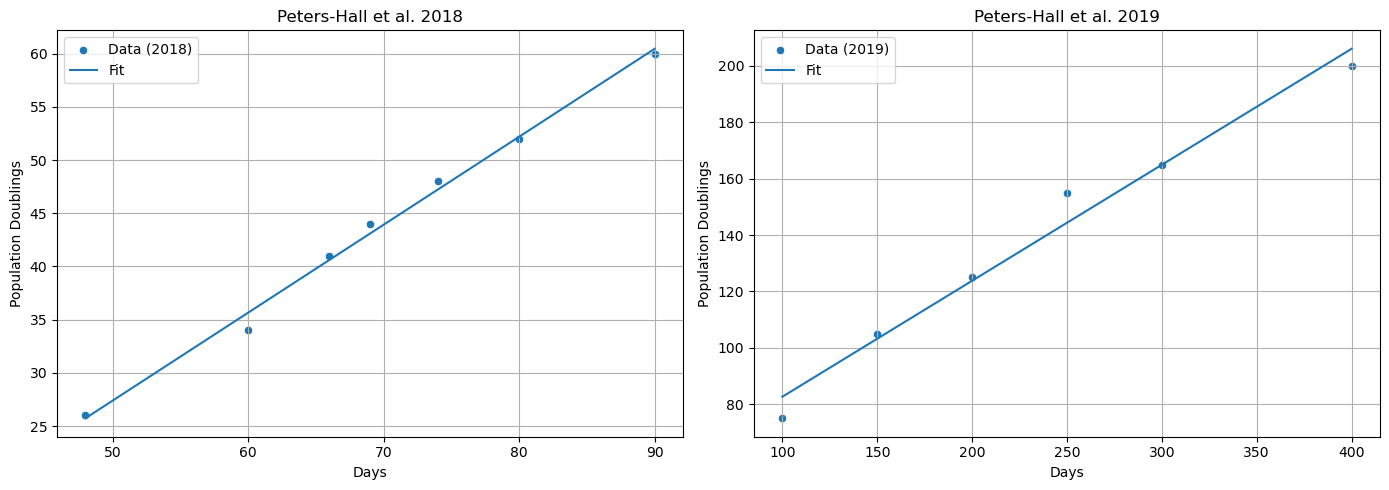

In [5]:
# Plotting both datasets in subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, ax in enumerate(axes):
    if i == 0: 
        data = bbc_pd_digitized_2018
        data_est = est_2018
        year = '2018'
    elif i == 1:
        data = bbc_pd_digitized_2019
        data_est = est_2019
        year = '2019'

    sns.scatterplot(data=data, x='day', y='PD', ax=ax, label=f'Data ({year})')
    sns.lineplot(x=data['day'], y=data_est['slope_doublings_per_day'] * data['day'] + data_est['intercept'], ax=ax, label='Fit')
    
    ax.set_title(f'Peters-Hall et al. {year}')
    ax.set_xlabel('Days')
    ax.set_ylabel('Population Doublings')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [11]:
# r_b | mean

r_b_mean = st.gmean([r_b_lower_per_day['mean']] + bbc_growth_summary['r_per_day'].tolist())
r_b_mean

np.float64(0.24586062338360715)

In [17]:
# import numpy as np
# import pandas as pd
# from scipy import stats
# from scipy.stats import truncnorm, t

# ---------------------------
# 1) User-provided digitized data
# ---------------------------
bbc_pd_digitized_2019 = pd.DataFrame([
    [100, 75],
    [150, 105],
    [200, 125],
    [250, 155],
    [300, 165],
    [400, 200]
], columns=['day', 'PD'])

bbc_pd_digitized_2018 = pd.DataFrame([
    [48, 26],
    [60, 34],
    [66, 41],
    [69, 44],
    [74, 48],
    [80, 52],
    [90, 60]
], columns=['day', 'PD'])

DAYS_PER_YEAR = 365.2425
r_b_lower_per_day = {'mean': 1/11, 'range_low': 1/(11+4.4), 'range_high': 1/(11-4.4)}

# ---------------------------
# 2) Fit slopes (doublings/day) and compute r_per_day (+ stderr)
# ---------------------------
def r_estimation_from_pd(pd_digitized, DAYS_PER_YEAR=365.2425):
    days = pd_digitized['day'].values
    doublings = pd_digitized['PD'].values
    res = st.linregress(days, doublings)  # slope, intercept, rvalue, pvalue, stderr
    slope = float(res.slope)
    intercept = float(res.intercept)
    slope_stderr = float(res.stderr) if res.stderr is not None else np.nan
    log2e = np.log2(np.e)
    r_per_day = slope / log2e
    r_per_year = r_per_day * DAYS_PER_YEAR
    return {
        'slope_doublings_per_day': slope,
        'slope_stderr': slope_stderr,
        'intercept': intercept,
        'r_per_day': r_per_day,
        'r_per_year': r_per_year,
        'r_squared': float(res.rvalue**2)
    }

est_2019 = r_estimation_from_pd(bbc_pd_digitized_2019, DAYS_PER_YEAR)
est_2018 = r_estimation_from_pd(bbc_pd_digitized_2018, DAYS_PER_YEAR)

bbc_growth_summary = pd.DataFrame([
    {'Dataset': 'Peters-Hall et al. 2019', **est_2019},
    {'Dataset': 'Peters-Hall et al. 2018', **est_2018}
])

# ---------------------------
# 3) Measurement-aware pipeline: Monte Carlo propagate uncertainties -> geometric mean + 95% CI
# ---------------------------
rng = np.random.default_rng(0)
N_MC = 10000
log2e = np.log2(np.e)

# sample lower-period: period ~ Normal(11, 4.4) truncated at >0, then r = 1/period
period_mean = 11.0
period_sd = 4.4
a_period, b_period = (1e-9 - period_mean) / period_sd, np.inf
period_samples = st.truncnorm.rvs(a_period, b_period, loc=period_mean, scale=period_sd, size=N_MC, random_state=rng)
r_lower_samples = 1.0 / period_samples  # shape (N_MC,)

# prepare slope means and stderrs for uppers
slope_means = bbc_growth_summary['slope_doublings_per_day'].values
slope_ses = bbc_growth_summary['slope_stderr'].values  # may contain nan

# vectorized sampling of slopes: for each slope i, create N_MC samples (truncated at 0)
k = slope_means.size
slopes_samples = np.empty((N_MC, k), dtype=float)
for i in range(k):
    mu = float(slope_means[i])
    se = float(slope_ses[i]) if not np.isnan(slope_ses[i]) else 0.0
    if se <= 0:
        slopes_samples[:, i] = mu
    else:
        a, b = (0.0 - mu) / se, np.inf
        slopes_samples[:, i] = st.truncnorm.rvs(a, b, loc=mu, scale=se, size=N_MC, random_state=rng)

# convert sampled slopes -> r_per_day
r_uppers_samples = slopes_samples / log2e  # shape (N_MC, k)

# assemble full r matrix (lower + all uppers) and compute geometric mean per MC draw
r_all_samples = np.concatenate([r_lower_samples.reshape(N_MC, 1), r_uppers_samples], axis=1)  # (N_MC, 1+k)
# guard against non-positive by small floor
r_all_samples[r_all_samples <= 0] = 1e-15
log_r = np.log(r_all_samples)
mc_geom_means = np.exp(log_r.mean(axis=1))  # geometric mean per MC draw, shape (N_MC,)

# summarize MC
gm_median_per_day = np.median(mc_geom_means)
gm_mean_per_day = np.mean(mc_geom_means)
gm_ci_low_per_day, gm_ci_high_per_day = np.percentile(mc_geom_means, [2.5, 97.5])

# analytic log-t CI on observed point estimates (lower mean + point slope means -> r_obs)
obs_r_values = np.concatenate(([r_b_lower_per_day['mean']], (slope_means / log2e)))
def geom_mean_logt_ci(r_values, alpha=0.05):
    r = np.asarray(r_values, dtype=float)
    if np.any(r <= 0):
        raise ValueError("r must be positive")
    n = r.size
    if n == 1:
        return {'gm': float(r[0]), 'ci_low': float(r[0]), 'ci_high': float(r[0])}
    logr = np.log(r)
    mean_log = logr.mean()
    sd_log = logr.std(ddof=1)
    se_log = sd_log / np.sqrt(n)
    tcrit = st.t.ppf(1 - alpha/2, df=n-1)
    ci_log = (mean_log - tcrit*se_log, mean_log + tcrit*se_log)
    return {'gm': float(np.exp(mean_log)), 'ci_low': float(np.exp(ci_log[0])), 'ci_high': float(np.exp(ci_log[1]))}

analytic = geom_mean_logt_ci(obs_r_values, alpha=0.05)

# ---------------------------
# 4) Print concise results
# ---------------------------
print("bbc_growth_summary:")
print(bbc_growth_summary[['Dataset','slope_doublings_per_day','slope_stderr','r_per_day','r_per_year','r_squared']].to_string(index=False))
print("\nLower-rate (period 11±4.4 days):", r_b_lower_per_day)
print("\nMonte Carlo (measurement-propagated) geometric mean (per day):")
print(f"  median GM = {gm_median_per_day:.9e} day^-1")
print(f"  mean   GM = {gm_mean_per_day:.9e} day^-1")
print(f"  95% CI = [{gm_ci_low_per_day:.9e}, {gm_ci_high_per_day:.9e}] day^-1")

print("\nMonte Carlo (per year):")
print(f"  median GM = {gm_median_per_day * DAYS_PER_YEAR:.6e} year^-1")
print(f"  95% CI = [{gm_ci_low_per_day * DAYS_PER_YEAR:.6e}, {gm_ci_high_per_day * DAYS_PER_YEAR:.6e}] year^-1")

print("\nAnalytic log-t geometric mean (point estimates only) per day:")
print(f"  GM = {analytic['gm']:.9e} day^-1")
print(f"  95% CI = [{analytic['ci_low']:.9e}, {analytic['ci_high']:.9e}] day^-1")


bbc_growth_summary:
                Dataset  slope_doublings_per_day  slope_stderr  r_per_day  r_per_year  r_squared
Peters-Hall et al. 2019                 0.411429      0.030229   0.285181  104.160059   0.978864
Peters-Hall et al. 2018                 0.827017      0.028760   0.573244  209.373165   0.993990

Lower-rate (period 11±4.4 days): {'mean': 0.09090909090909091, 'range_low': 0.06493506493506493, 'range_high': 0.15151515151515152}

Monte Carlo (measurement-propagated) geometric mean (per day):
  median GM = 2.456261163e-01 day^-1
  mean   GM = 2.583321815e-01 day^-1
  95% CI = [2.010931244e-01, 3.894767072e-01] day^-1

Monte Carlo (per year):
  median GM = 8.971310e+01 year^-1
  95% CI = [7.344776e+01, 1.422534e+02] year^-1

Analytic log-t geometric mean (point estimates only) per day:
  GM = 2.458606234e-01 day^-1
  95% CI = [2.441977667e-02, 2.475348033e+00] day^-1


## Proliferation limit $H$

In [28]:
# Linear interpolation of PD vs O2 endpoints

# endpoints: (O2 pct, PD count)
o2_21, pd_21 = 21, 40
o2_2,  pd_2  = 2,  220

# compute slope (m) and intercept (b) for PD = m*O2 + b
m = (pd_2 - pd_21) / (o2_2 - o2_21)
b = pd_21 - m * o2_21

# evaluate at 7% O2
o2_target = 7
pd_target = m * o2_target + b

# print exact fractional values and float approximations
print("slope m =", m, "≈", m)
print("intercept b =", b, "≈", b)
print(f"PD at {o2_target}% O2 = {pd_target} ≈ {pd_target:.0f}")

slope m = -9.473684210526315 ≈ -9.473684210526315
intercept b = 238.9473684210526 ≈ 238.9473684210526
PD at 7% O2 = 172.63157894736838 ≈ 173


In [35]:
60e6/(10e9)*100

0.6

### BBC division types

In [91]:
# Lower bounds for basal cell loss at influenza-caused injury from Fujino et al. (2019)
0.5/4.2, 0.005/0.024

(0.11904761904761904, 0.20833333333333334)

Parameters: a = 3.561990, q_small = -3.444682, q_xb = 0.000000
B/K=0.00 -> f_bb=0.3461, f_xb=0.3078, f_xx=0.3461, f_sym=0.6922
B/K=0.25 -> f_bb=0.2400, f_xb=0.5200, f_xx=0.2400, f_sym=0.4800
B/K=1.00 -> f_bb=0.0300, f_xb=0.9400, f_xx=0.0300, f_sym=0.0600


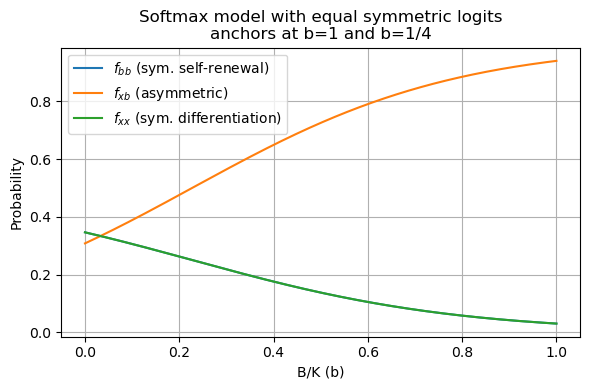

In [94]:
from scipy.special import logsumexp

# Anchors
b1, fsym1 = 1.0, 0.06    # homeostasis: f_sym = 2*0.03 = 0.06 at B/K = 1
b2, fsym2 = 1/4, 0.48   # injury:    f_sym = 0.48  at B/K = 1/4

# baseline asymmetric logit (arbitrary reference; shifting q_xb shifts symmetric logits similarly)
q_xb = 0.0

# helper: r = exp(h - q_xb) from f_sym = 2 r / (1 + 2 r) -> r = f_sym/(2 (1-f_sym))
def r_from_fsym(f):
    return f / (2.0 * (1.0 - f))

r1 = r_from_fsym(fsym1)
r2 = r_from_fsym(fsym2)

# Solve for linear logit h(b) = a*(1-b) + q_small
# h(b1) = ln r1 + q_xb, h(b2) = ln r2 + q_xb
h1 = np.log(r1) + q_xb
h2 = np.log(r2) + q_xb
a = (h2 - h1) / (1.0 - b2)
q_small = h1   # h(b=1)

# vectorised functions
def h_of_b(b):
    return a * (1.0 - b) + q_small

def probs_for_b_array(bs):
    h = h_of_b(bs)
    # logits order: [l_bb, l_xb, l_xx] with l_bb = l_xx = h(b)
    logits = np.vstack((h, np.full_like(h, q_xb), h))
    denom = logsumexp(logits, axis=0)
    probs = np.exp(logits - denom)   # shape (3, N)
    return probs

# compute and plot for B/K in [0,1]
bs = np.linspace(0.0, 1.0, 501)
probs = probs_for_b_array(bs)  # rows: f_bb, f_xb, f_xx

# print parameters + sample values
print("Parameters: a = {:.6f}, q_small = {:.6f}, q_xb = {:.6f}".format(a, q_small, q_xb))
for s in (0.0, 0.25, 1.0):
    i = np.argmin(np.abs(bs - s))
    print(f"B/K={bs[i]:.2f} -> f_bb={probs[0,i]:.4f}, f_xb={probs[1,i]:.4f}, f_xx={probs[2,i]:.4f}, f_sym={probs[0,i]+probs[2,i]:.4f}")

plt.figure(figsize=(6,4))
plt.plot(bs, probs[0,:], label=r'$f_{bb}$ (sym. self-renewal)')
plt.plot(bs, probs[1,:], label=r'$f_{xb}$ (asymmetric)')
plt.plot(bs, probs[2,:], label=r'$f_{xx}$ (sym. differentiation)')
plt.xlabel('B/K (b)')
plt.ylabel('Probability')
plt.title('Softmax model with equal symmetric logits\nanchors at b=1 and b=1/4')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()